Dataset Shape: (1398, 67)

First 5 rows:
  Customer ID  Gender   Age Category  Unit Price  Quantity  Sales  \
0    CUST0269    Male  64.0  Bottoms       100.0         3    300   
1    CUST0237    Male  65.0     Tops       200.0         3    600   
2    CUST0240  Female  39.0     Tops       100.0         1    100   
3    CUST0252  Female  55.0     Tops       200.0         5   1000   
4    CUST0183  Female  42.0  Bottoms       800.0         3   2400   

   Shipping Fee Shipping Status  Order Date  ... Delivery_Delay  \
0         11.64        Returned  2019-06-02  ...             -1   
1          6.94      In Transit  2021-05-18  ...              0   
2          7.09       Delivered  2020-01-21  ...              0   
3         13.29       Delivered  2021-05-17  ...             -1   
4          7.22       Delivered  2024-08-05  ...              0   

  Unexpected_Demand_Spike_Flag  Supplier_Performance_Score  \
0                            0                          95   
1                

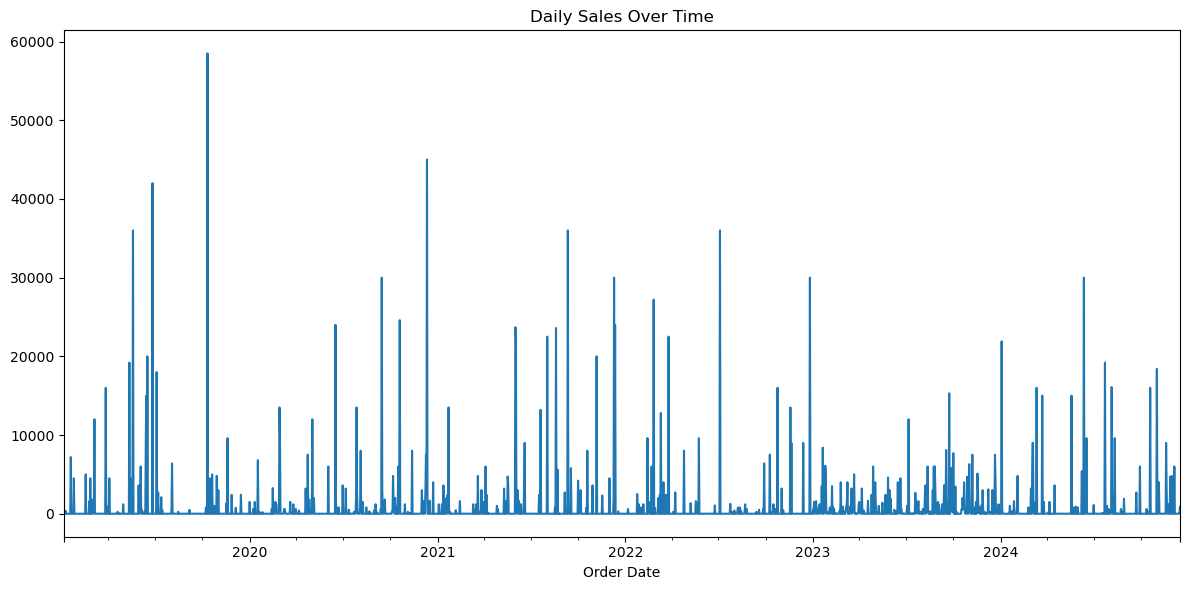

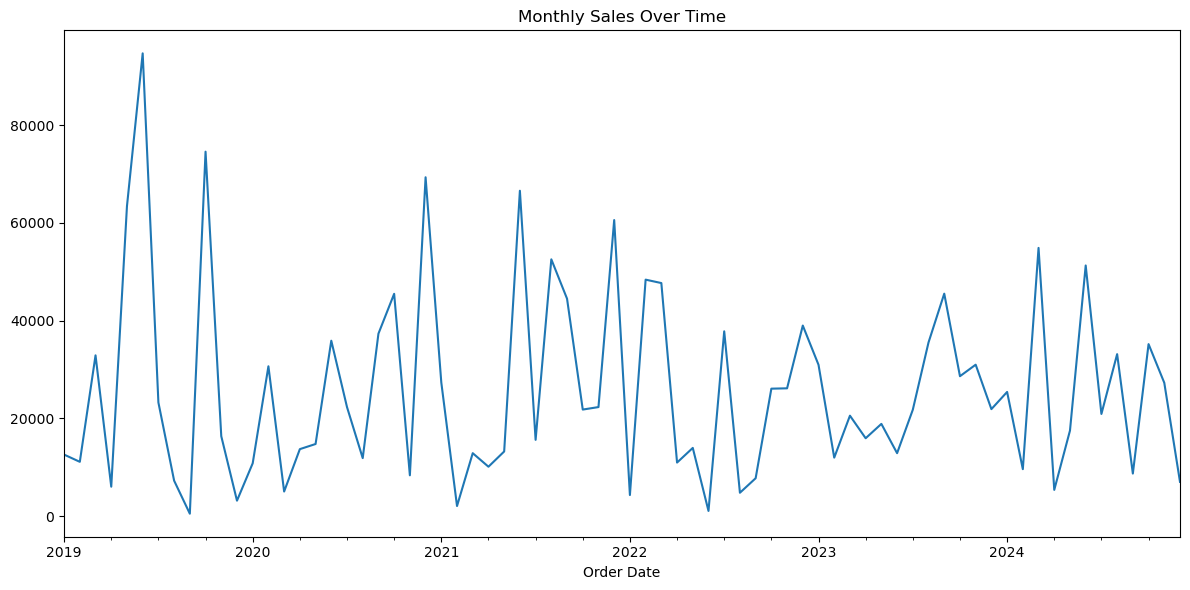

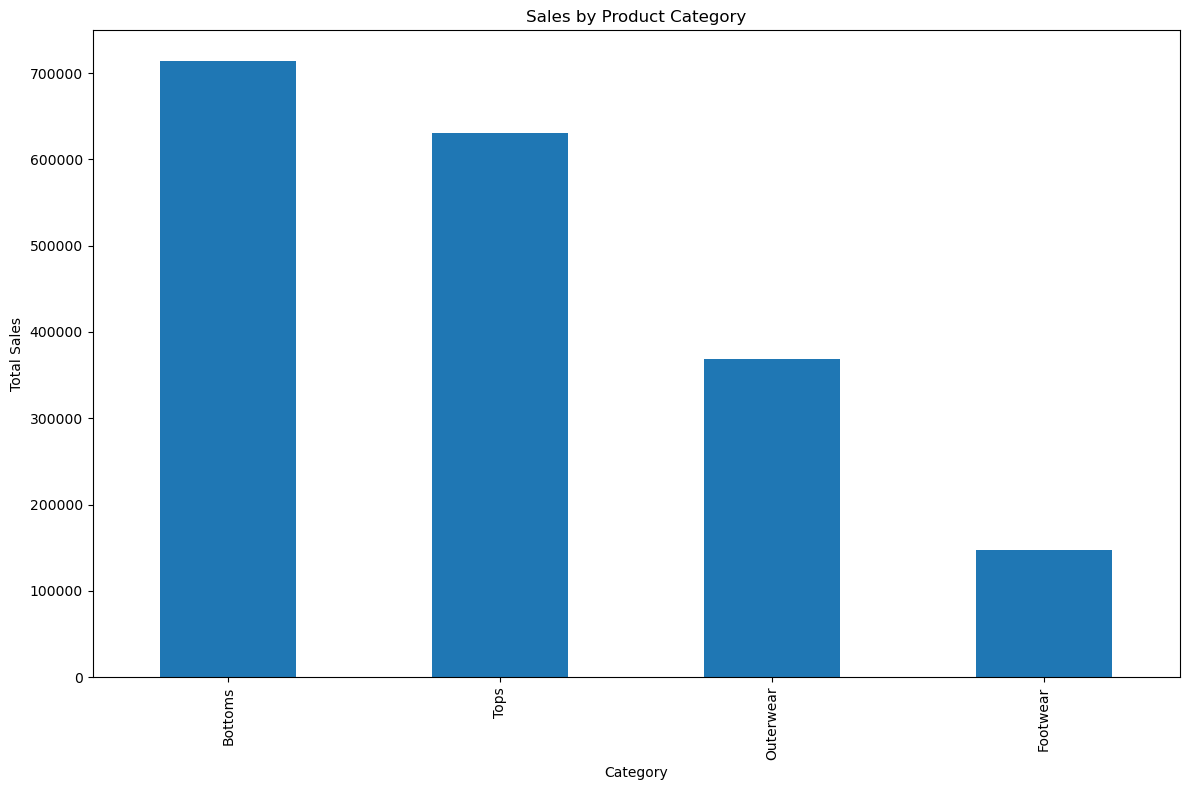

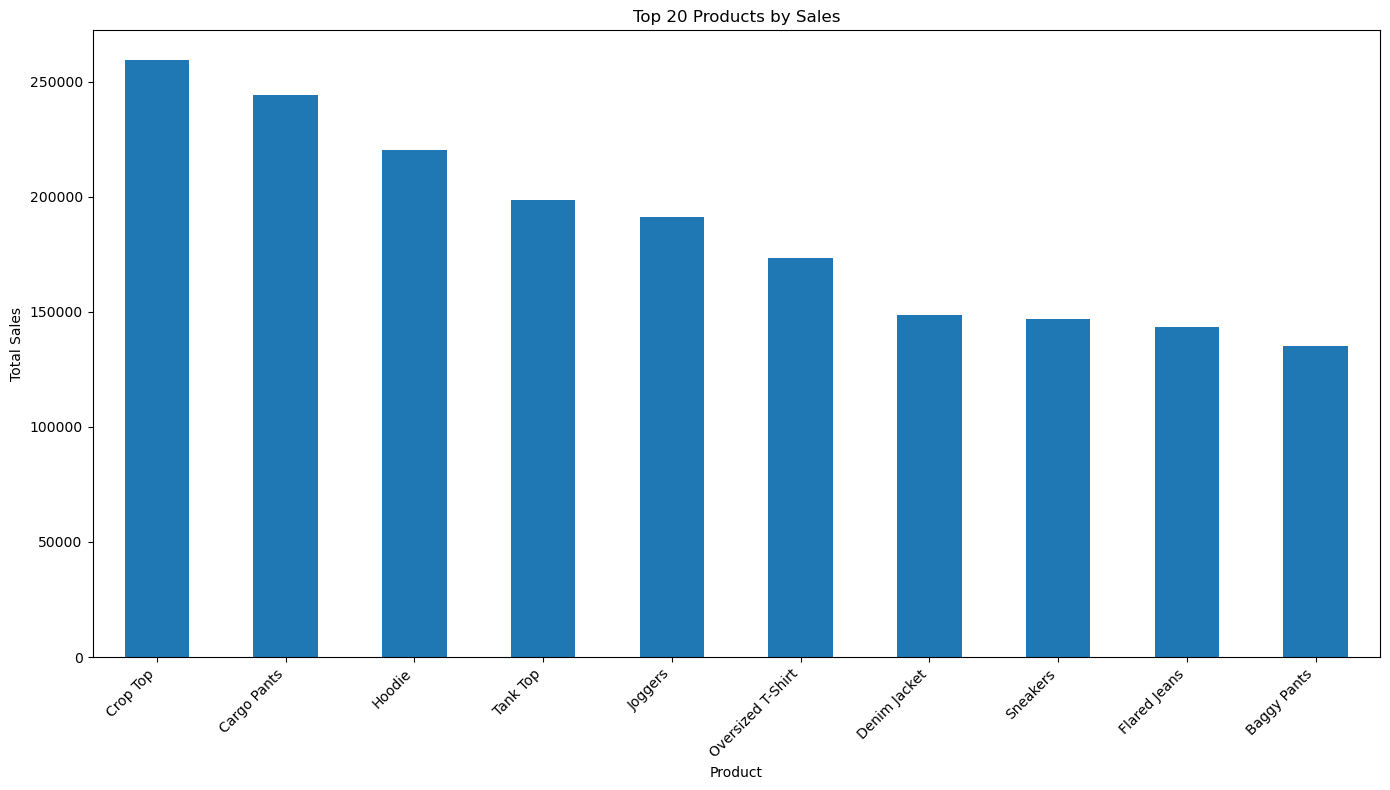

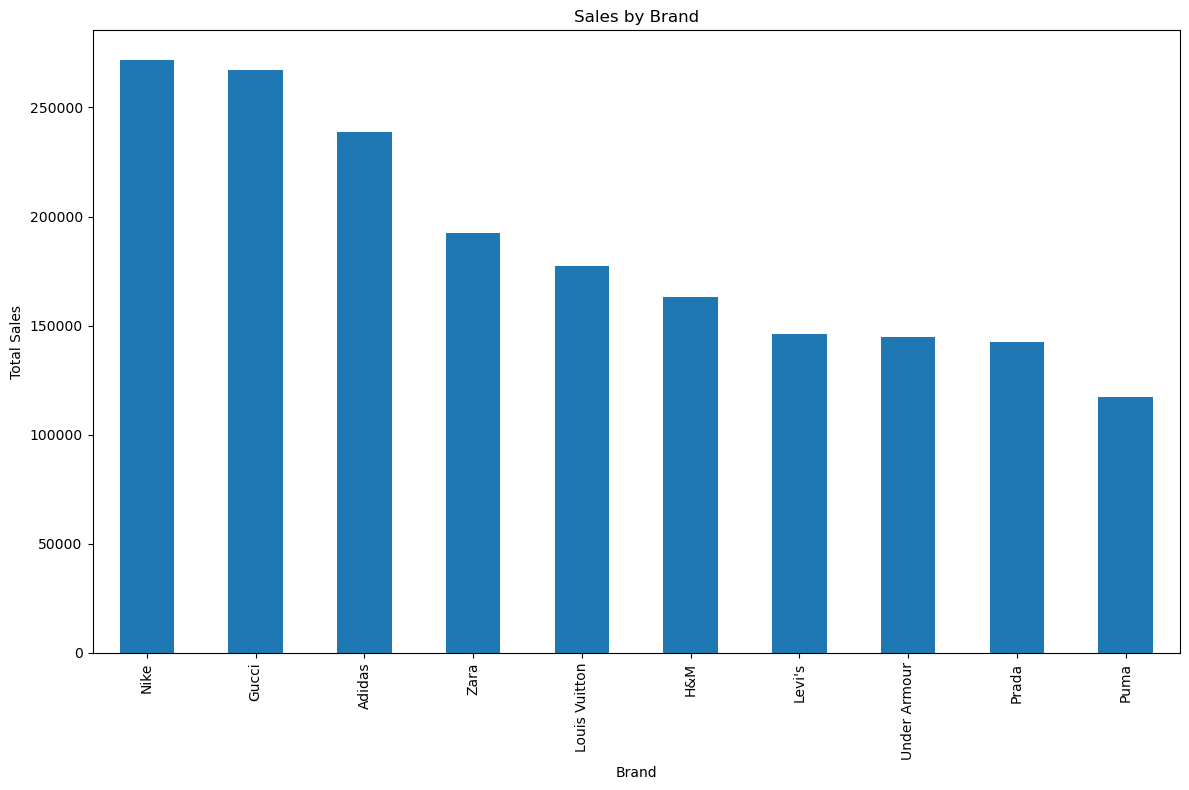

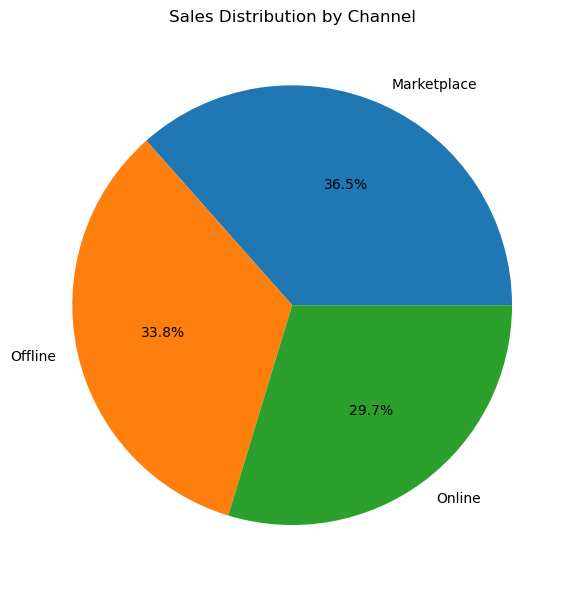

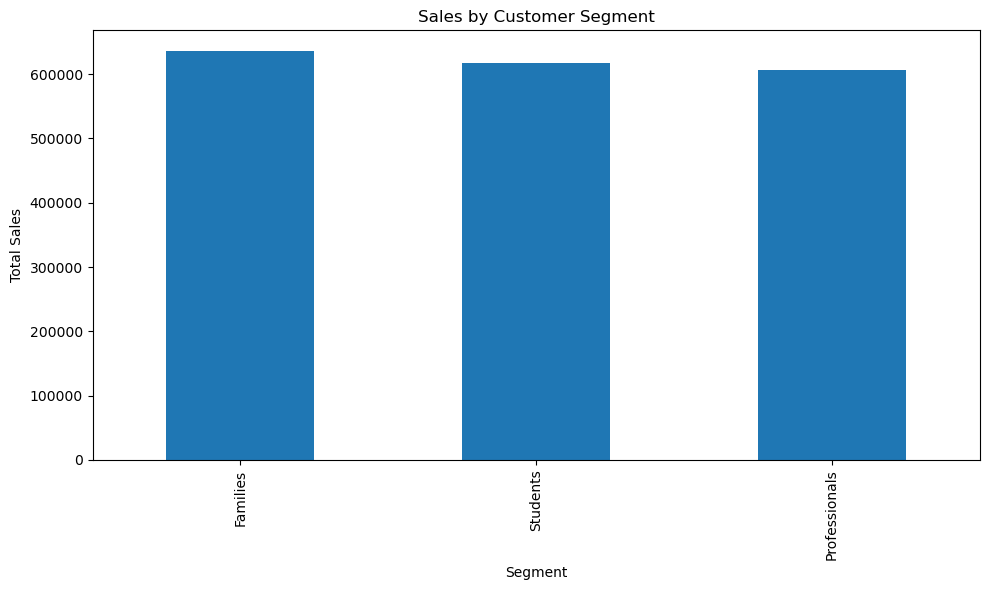

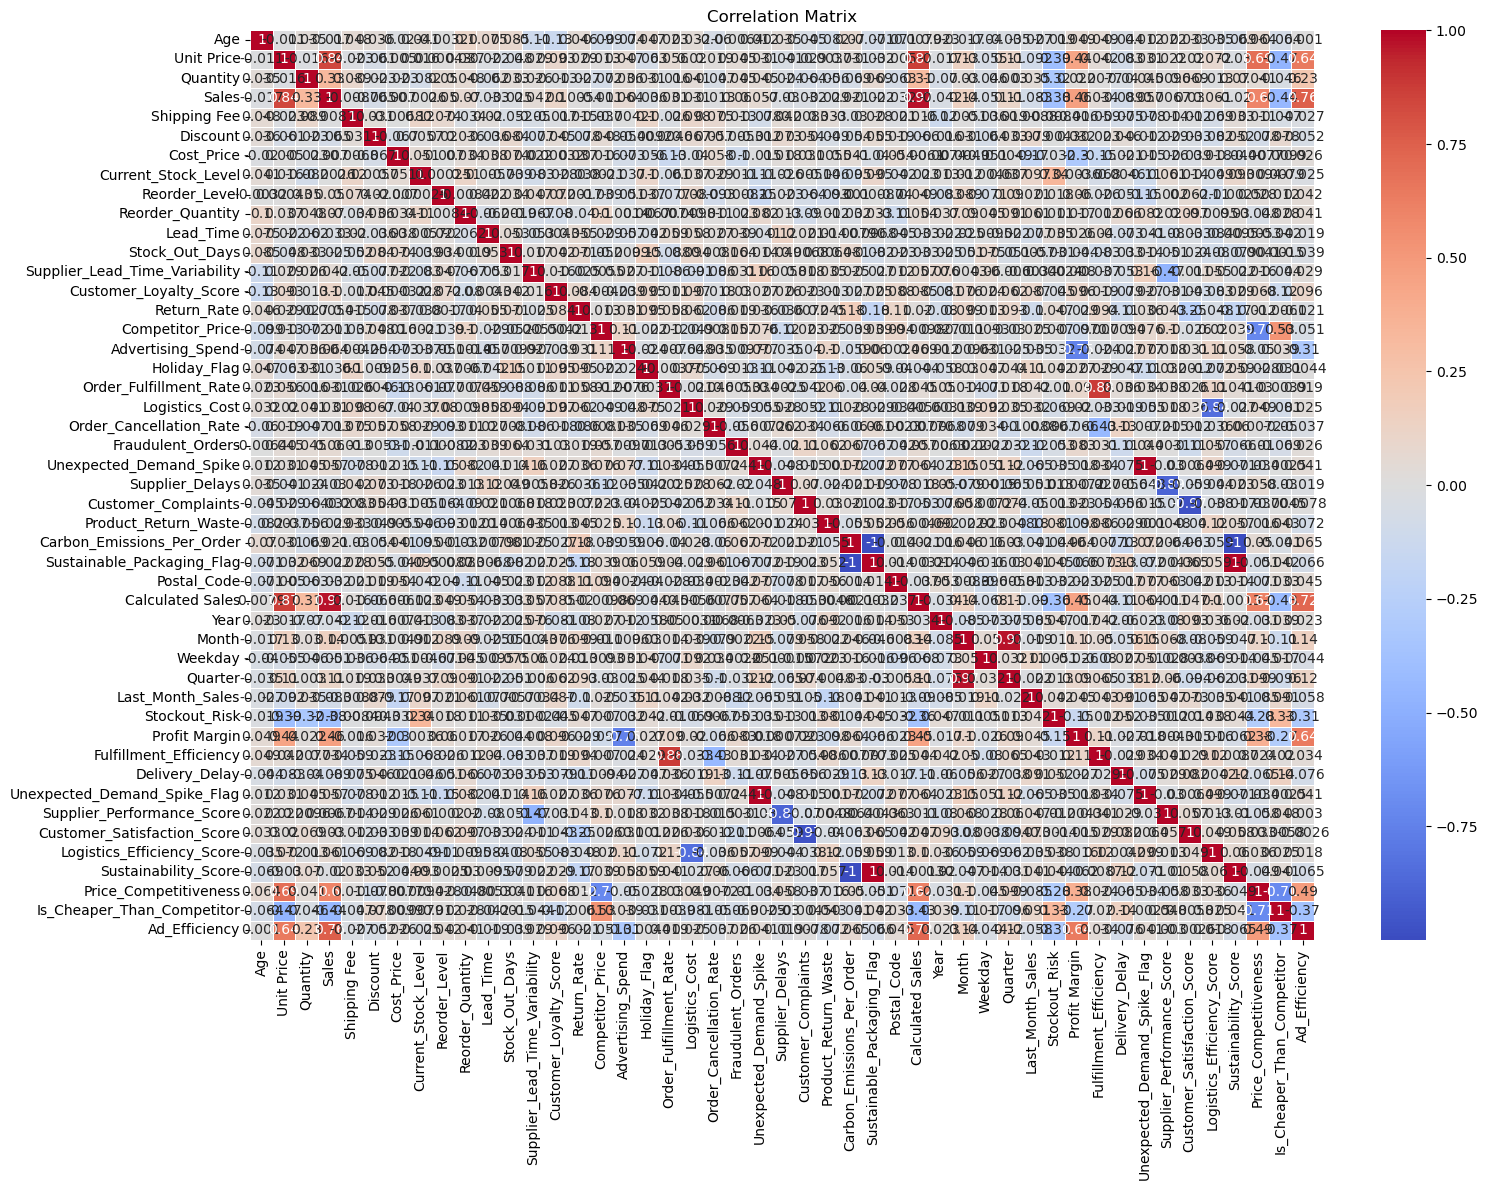

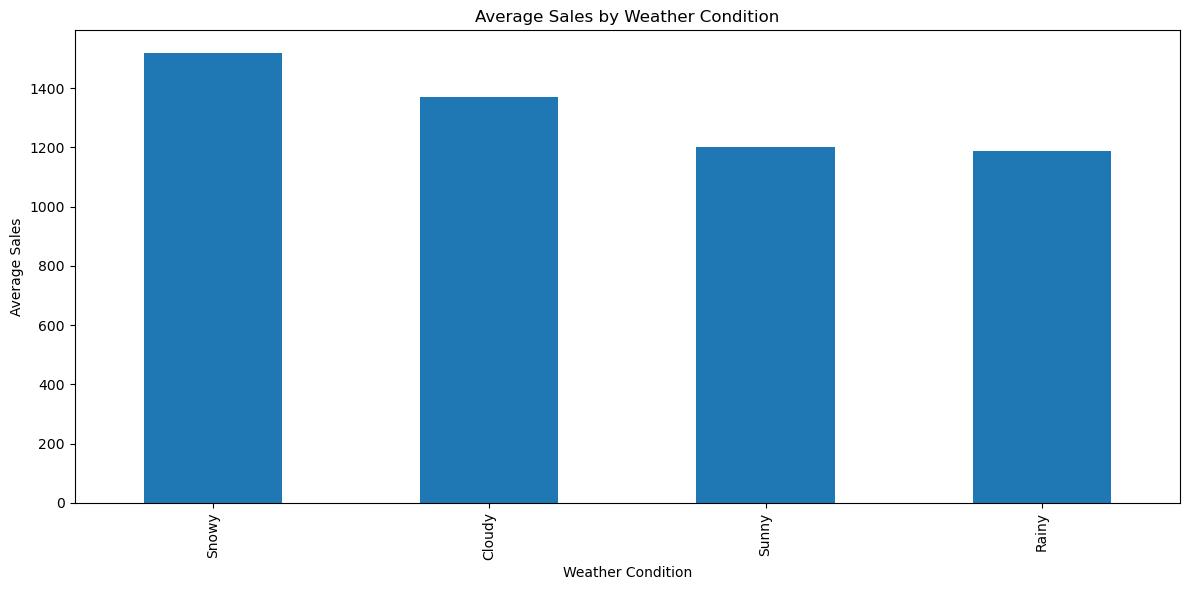

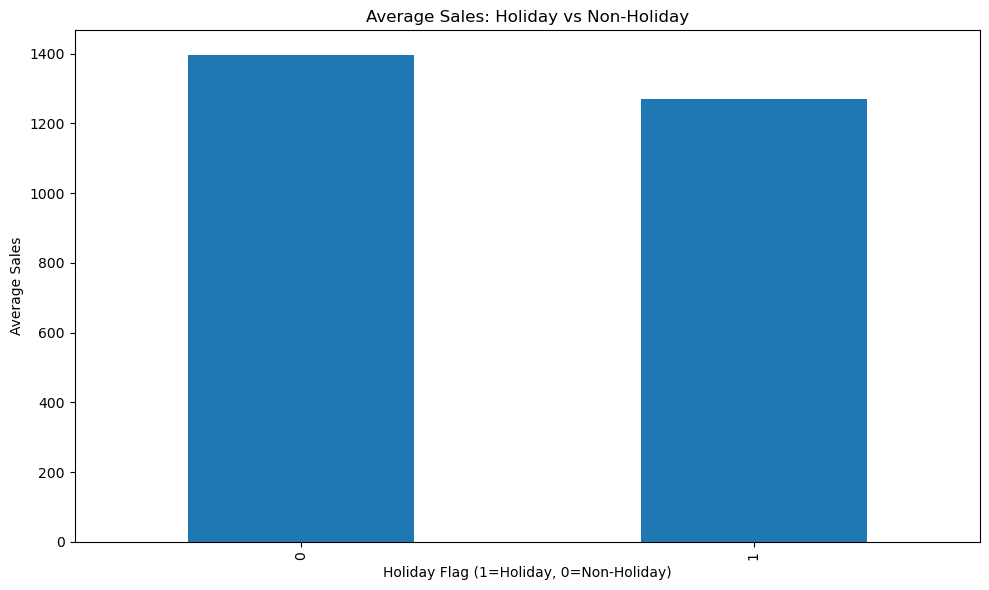

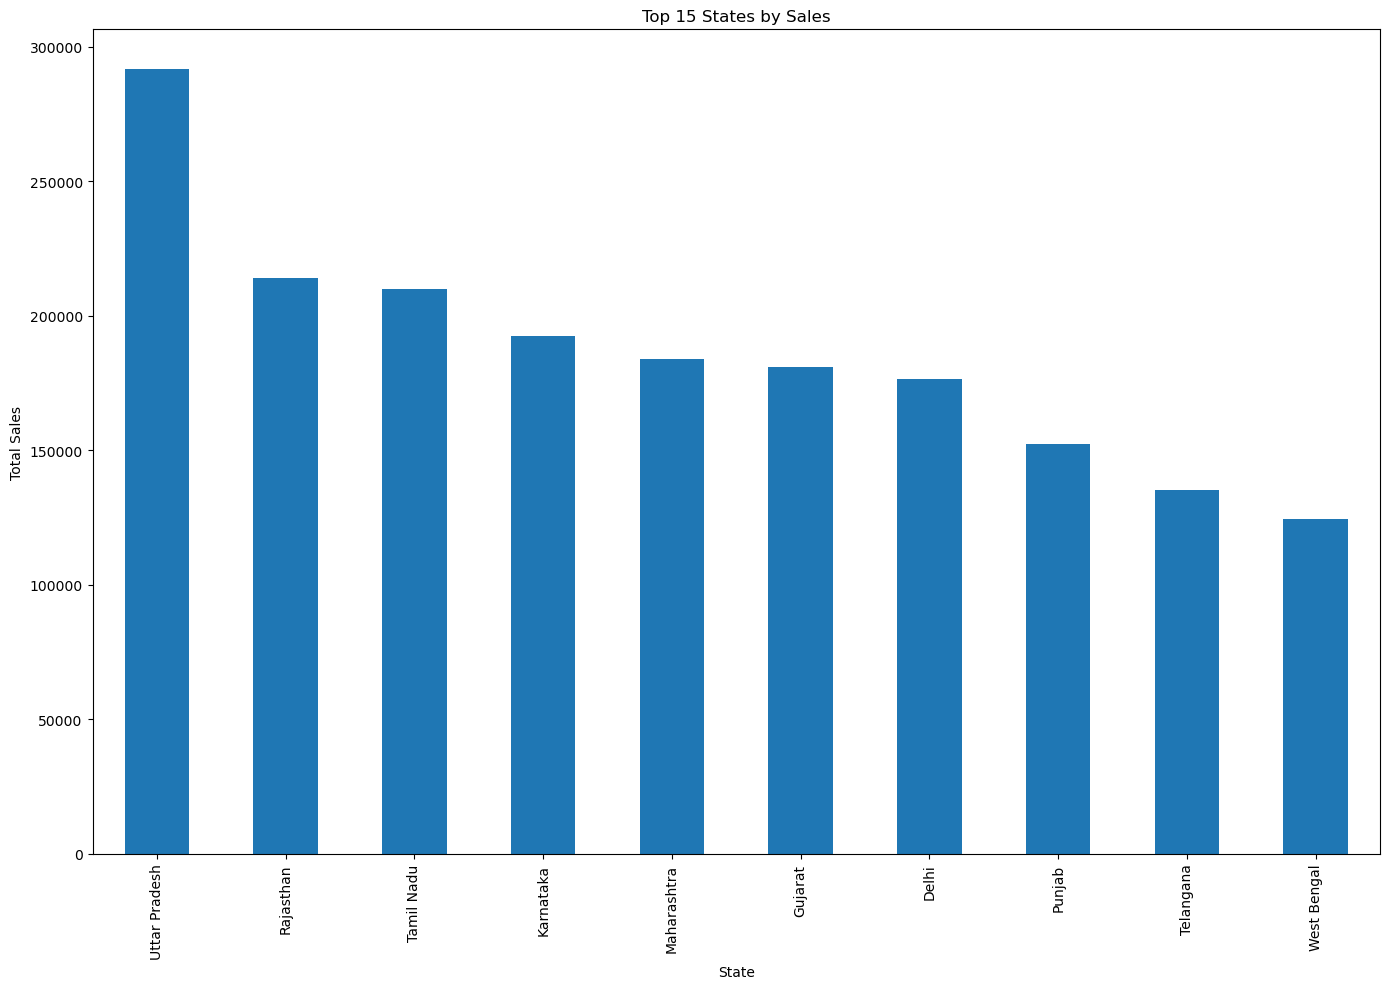

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import datetime
from prophet import Prophet

# Load the dataset
# Replace 'your_ecommerce_data.csv' with your actual file path
df = pd.read_csv('/Users/arjavkasliwal/Downloads/finaldatasetecom.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
# Set Order Date as index for time series analysis
df_ts = df.copy()
df_ts.set_index('Order Date', inplace=True)

# Basic sales analysis
plt.figure(figsize=(12, 6))
plt.title("Daily Sales Over Time")
df_ts['Sales'].resample('D').sum().plot()
plt.tight_layout()
plt.show()

# Monthly sales trend
plt.figure(figsize=(12, 6))
plt.title("Monthly Sales Over Time")
monthly_sales = df_ts['Sales'].resample('M').sum()
monthly_sales.plot()
plt.tight_layout()
plt.show()

# Sales by category
plt.figure(figsize=(12, 8))
category_sales = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
category_sales.plot(kind='bar')
plt.title('Sales by Product Category')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# Sales by product
plt.figure(figsize=(14, 8))
product_sales = df.groupby('Product')['Sales'].sum().sort_values(ascending=False).head(20)
product_sales.plot(kind='bar')
plt.title('Top 20 Products by Sales')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sales by brand
plt.figure(figsize=(12, 8))
brand_sales = df.groupby('Brand')['Sales'].sum().sort_values(ascending=False).head(15)
brand_sales.plot(kind='bar')
plt.title('Sales by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# Sales channels analysis
plt.figure(figsize=(10, 6))
channel_sales = df.groupby('Sales_Channel')['Sales'].sum().sort_values(ascending=False)
channel_sales.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sales Distribution by Channel')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Customer segment analysis
plt.figure(figsize=(10, 6))
segment_sales = df.groupby('Customer_Segment')['Sales'].sum().sort_values(ascending=False)
segment_sales.plot(kind='bar')
plt.title('Sales by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# Correlation analysis for numerical variables
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation = df[numerical_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Analyze how weather conditions affect sales
plt.figure(figsize=(12, 6))
weather_sales = df.groupby('Weather_Conditions')['Sales'].mean().sort_values(ascending=False)
weather_sales.plot(kind='bar')
plt.title('Average Sales by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

# Holiday impact on sales
plt.figure(figsize=(10, 6))
holiday_sales = df.groupby('Holiday_Flag')['Sales'].mean()
holiday_sales.plot(kind='bar')
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.xlabel('Holiday Flag (1=Holiday, 0=Non-Holiday)')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

# Geographic analysis
plt.figure(figsize=(14, 10))
state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False).head(15)
state_sales.plot(kind='bar')
plt.title('Top 15 States by Sales')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

# Create a copy of the dataframe
df_processed = df.copy()

# Convert categorical variables to appropriate types
categorical_cols = ['Gender', 'Category', 'Shipping Status', 'Brand', 
                    'Sales_Channel', 'Customer_Segment', 'Warehouse_ID', 
                    'Weather_Conditions', 'State', 'City', 'Product']

for col in categorical_cols:
    df_processed[col] = df_processed[col].astype('category')

# Convert binary flags to proper binary format
binary_cols = ['Holiday_Flag', 'Sustainable_Packaging_Flag']
for col in binary_cols:
    df_processed[col] = df_processed[col].astype(int)

# Feature engineering
# Extract date components from Order Date
df_processed['Order Date'] = pd.to_datetime(df_processed['Order Date'], errors='coerce')
df_processed['Year'] = df_processed['Order Date'].dt.year
df_processed['Month'] = df_processed['Order Date'].dt.month
df_processed['Day'] = df_processed['Order Date'].dt.day
df_processed['DayOfWeek'] = df_processed['Order Date'].dt.dayofweek
df_processed['Quarter'] = df_processed['Order Date'].dt.quarter
df_processed['WeekOfYear'] = df_processed['Order Date'].dt.isocalendar().week
df_processed['Is_Weekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

# Convert Delivery_Time and Shipping_Time to numeric
df_processed['Delivery_Time'] = pd.to_numeric(df_processed['Delivery_Time'], errors='coerce')
df_processed['Shipping_Time'] = pd.to_numeric(df_processed['Shipping_Time'], errors='coerce')

# Handle any non-numeric characters in these columns
df_processed['Delivery_Time'] = df_processed['Delivery_Time'].astype(float)
df_processed['Shipping_Time'] = df_processed['Shipping_Time'].astype(float)

# Create profit column
df_processed['Profit'] = df_processed['Sales'] - (df_processed['Cost_Price'] * df_processed['Quantity'])
df_processed['Profit_Margin'] = df_processed['Profit'] / df_processed['Sales']

# Calculate price elasticity features
df_processed['Price_To_Competitor_Ratio'] = df_processed['Unit Price'] / df_processed['Competitor_Price']

# Create demand indicators
df_processed['Sales_Quantity_Ratio'] = df_processed['Quantity'] / df_processed['Current_Stock_Level']
df_processed['Stock_Coverage_Days'] = df_processed['Current_Stock_Level'] / (df_processed['Quantity'] / 30)

# Create customer value metrics
df_processed['Customer_Value'] = df_processed['Sales'] * df_processed['Customer_Loyalty_Score']

# Create logistics efficiency metrics
df_processed['Delivery_Efficiency'] = df_processed['Delivery_Time'] / df_processed['Shipping_Time']
df_processed['Logistics_Efficiency'] = df_processed['Order_Fulfillment_Rate'] / df_processed['Logistics_Cost']

# Create categorical interaction features
df_processed['Segment_Channel'] = df_processed['Customer_Segment'].astype(str) + '_' + df_processed['Sales_Channel'].astype(str)
df_processed['Category_Brand'] = df_processed['Category'].astype(str) + '_' + df_processed['Brand'].astype(str)

# Create bins for age groups
df_processed['Age_Group'] = pd.cut(
    df_processed['Age'],
    bins=[0, 18, 25, 35, 45, 55, 65, 100],
    labels=['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
)

# Create bins for unit price
df_processed['Price_Tier'] = pd.qcut(
    df_processed['Unit Price'],
    q=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Premium']
)

# Create customer lifetime value approximation
customer_frequency = df.groupby('Customer ID').size()
customer_recency = df.groupby('Customer ID')['Order Date'].max()
customer_monetary = df.groupby('Customer ID')['Sales'].sum()

# Combine into customer metrics dataframe
customer_metrics = pd.DataFrame({
    'Frequency': customer_frequency,
    'Recency': customer_recency,
    'Monetary': customer_monetary
})

# Merge customer metrics back to main dataframe
df_processed = df_processed.merge(
    customer_metrics.rename(columns={
        'Frequency': 'Customer_Purchase_Frequency',
        'Monetary': 'Customer_Total_Spend'
    }),
    left_on='Customer ID',
    right_index=True,
    how='left'
)

# Calculate days since last order
max_date = df_processed['Order Date'].max()
df_processed['Days_Since_Last_Order'] = (max_date - df_processed['Recency']).dt.days

# Drop redundant columns after feature engineering
df_processed.drop(['Recency'], axis=1, inplace=True)

# Save preprocessed data
df_processed.to_csv('preprocessed_ecommerce_data.csv', index=False)

print("Feature engineering completed. New dataframe shape:", df_processed.shape)
print("New features created:", len(df_processed.columns) - len(df.columns), "features")


Feature engineering completed. New dataframe shape: (1398, 86)
New features created: 19 features


Linear Regression Results:
RMSE: 599.1095893073319
R²: 0.8788030295490973

Random Forest Results:
RMSE: 49.33719402525557
R²: 0.9991780827142943

Gradient Boosting Results:
RMSE: 44.932910152769004
R²: 0.9993182764189361

Best model: Gradient Boosting with R² score of 0.9993182764189361


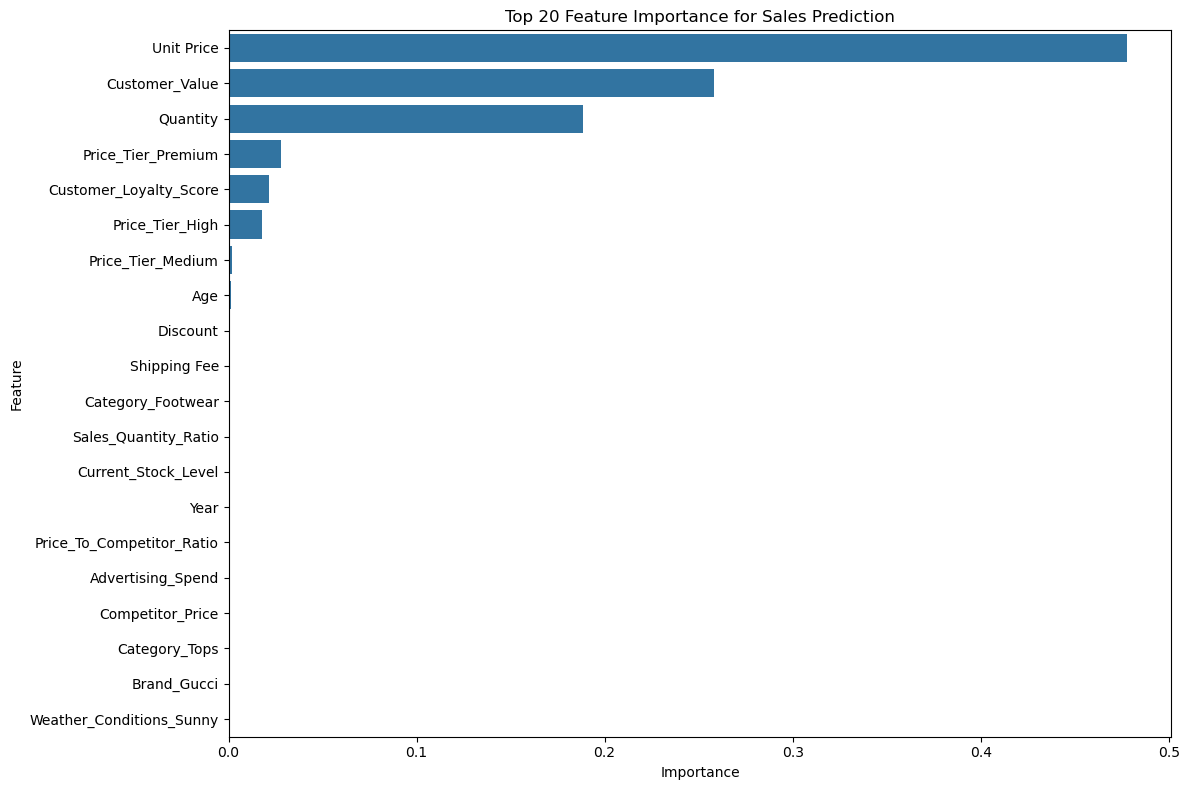


Top 10 Most Important Features:
                   Feature  Importance
2               Unit Price    0.477506
18          Customer_Value    0.258229
6                 Quantity    0.188337
45      Price_Tier_Premium    0.028039
1   Customer_Loyalty_Score    0.021739
42         Price_Tier_High    0.017823
44       Price_Tier_Medium    0.001813
0                      Age    0.001431
3                 Discount    0.000798
7             Shipping Fee    0.000713

Best model saved as 'best_sales_prediction_model.pkl'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the preprocessed data
df_processed = pd.read_csv('preprocessed_ecommerce_data.csv')

# Convert Order Date back to datetime
df_processed['Order Date'] = pd.to_datetime(df_processed['Order Date'])

# Define target variable and features
target = 'Sales'
features = [
    'Age', 'Gender', 'Customer_Segment', 'Customer_Loyalty_Score',
    'Category', 'Brand', 'Unit Price', 'Discount', 'Competitor_Price',
    'Price_To_Competitor_Ratio', 'Quantity', 'Shipping Fee',
    'Advertising_Spend', 'Weather_Conditions', 'Holiday_Flag',
    'Current_Stock_Level', 'Supplier_Lead_Time_Variability',
    'Year', 'Month', 'Quarter', 'DayOfWeek', 'Is_Weekend',
    'Sales_Quantity_Ratio', 'Customer_Value', 'Price_Tier'
]

# Prepare data for modeling
X = df_processed[features]
y = df_processed[target]

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['category', 'object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 1. Linear Regression Model
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression Results:")
print(f"RMSE: {lr_rmse}")
print(f"R²: {lr_r2}")

# 2. Random Forest Regressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("\nRandom Forest Results:")
print(f"RMSE: {rf_rmse}")
print(f"R²: {rf_r2}")

# 3. Gradient Boosting Regressor
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

gb_pipeline.fit(X_train, y_train)
gb_pred = gb_pipeline.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_r2 = r2_score(y_test, gb_pred)  # Fixed NameError

print("\nGradient Boosting Results:")
print(f"RMSE: {gb_rmse}")
print(f"R²: {gb_r2}")

# Determine the best model
models = {
    'Linear Regression': lr_r2,
    'Random Forest': rf_r2,
    'Gradient Boosting': gb_r2
}

best_model = max(models, key=models.get)
print(f"\nBest model: {best_model} with R² score of {models[best_model]}")

# Feature importance analysis (using Random Forest)
if hasattr(rf_pipeline.named_steps['regressor'], 'feature_importances_'):
    feature_names = (
        numerical_features.tolist() + 
        list(rf_pipeline.named_steps['preprocessor']
             .named_transformers_['cat']
             .get_feature_names_out(categorical_features))
    )
    
    feature_importance = rf_pipeline.named_steps['regressor'].feature_importances_
    
    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importance for Sales Prediction')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))

# Save the best model
if best_model == 'Linear Regression':
    joblib.dump(lr_pipeline, 'best_sales_prediction_model.pkl')
elif best_model == 'Random Forest':
    joblib.dump(rf_pipeline, 'best_sales_prediction_model.pkl')
else:
    joblib.dump(gb_pipeline, 'best_sales_prediction_model.pkl')

print("\nBest model saved as 'best_sales_prediction_model.pkl'")

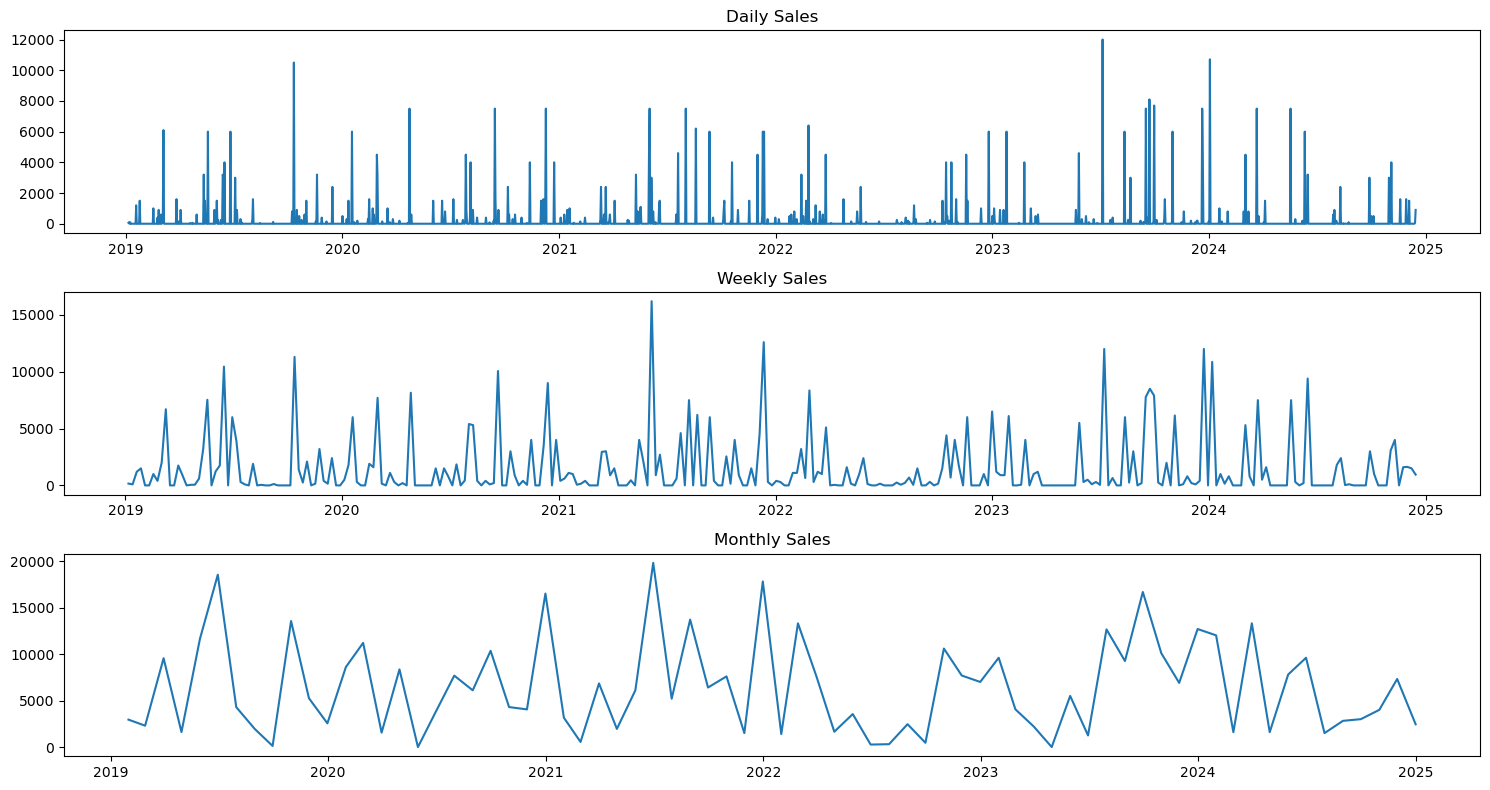

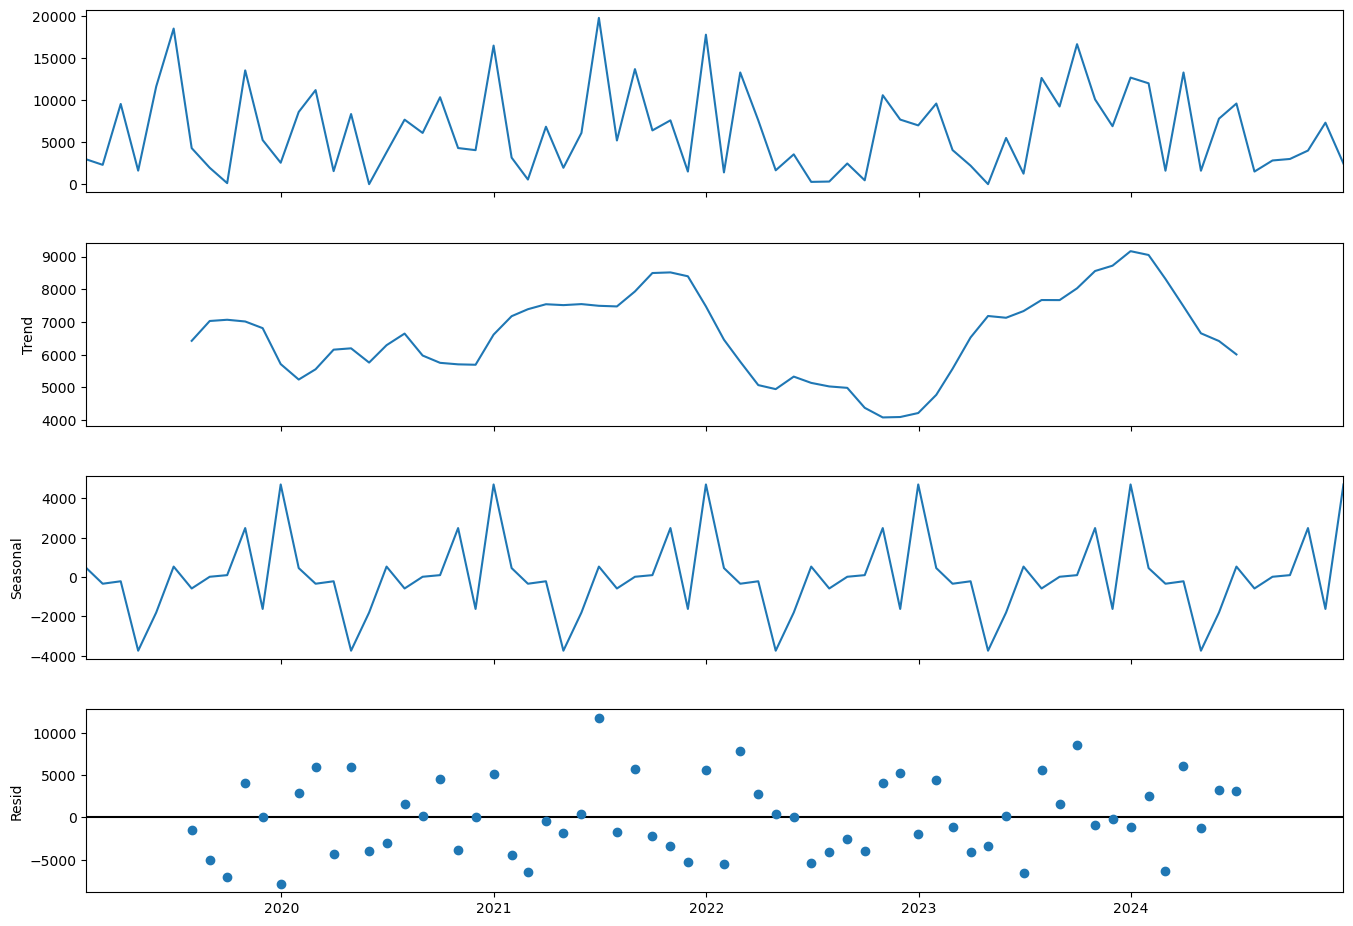

<Figure size 1600x1000 with 0 Axes>

13:11:21 - cmdstanpy - INFO - Chain [1] start processing
13:11:21 - cmdstanpy - INFO - Chain [1] done processing


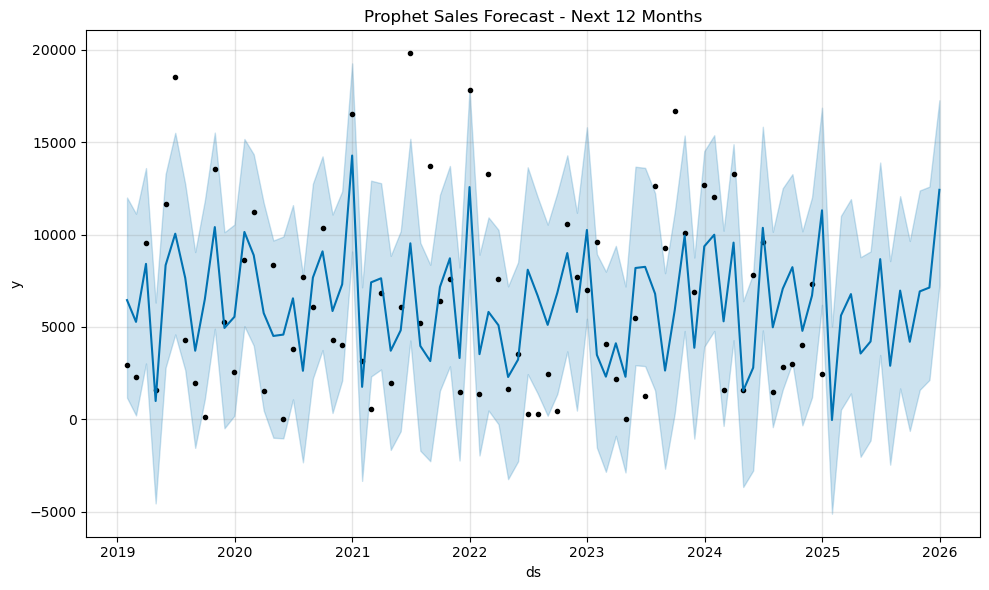

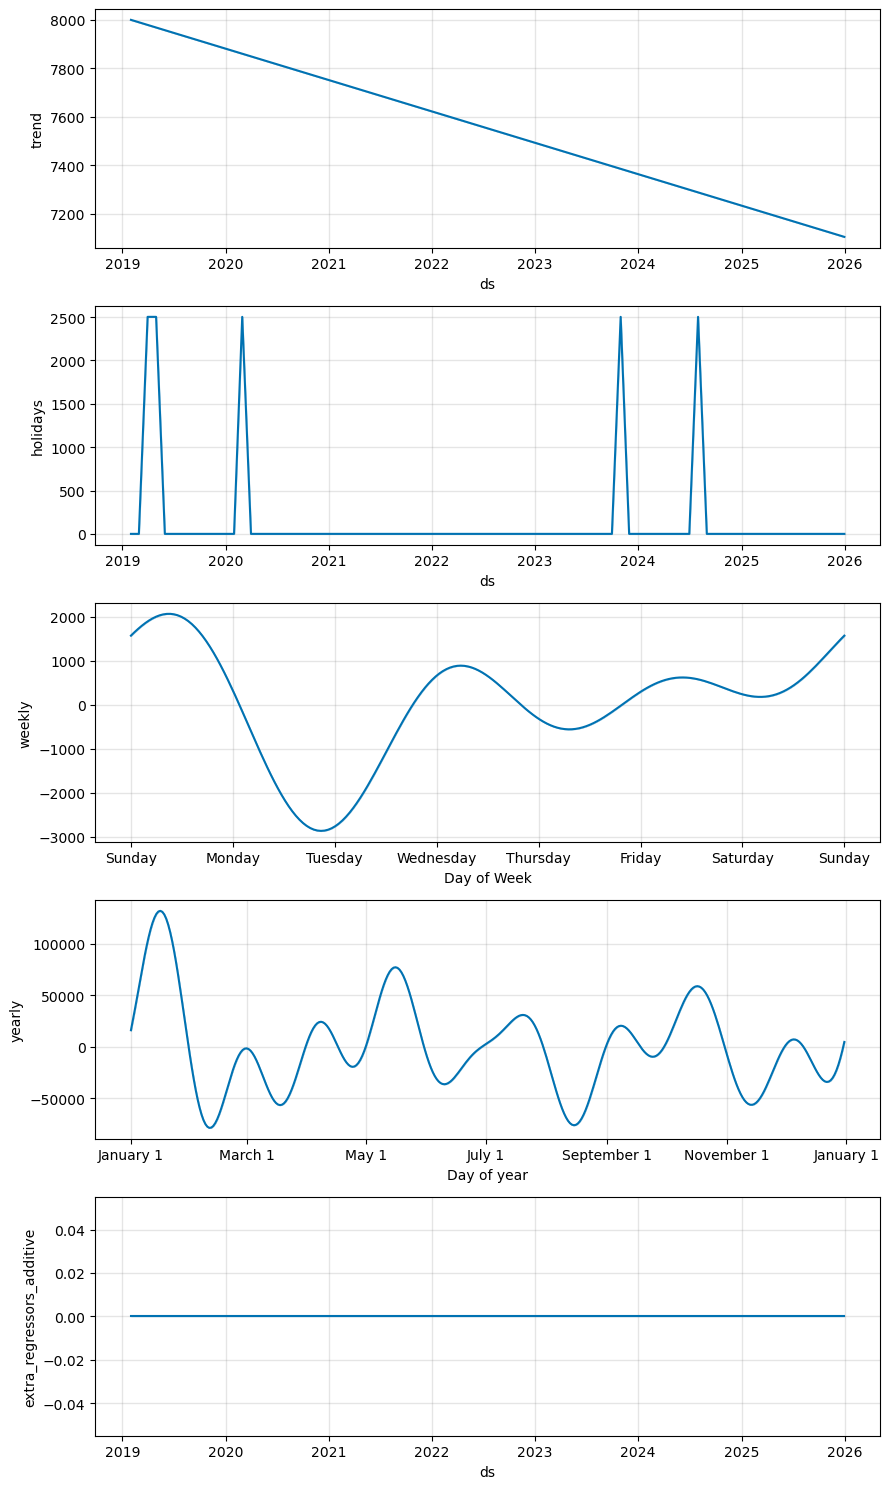

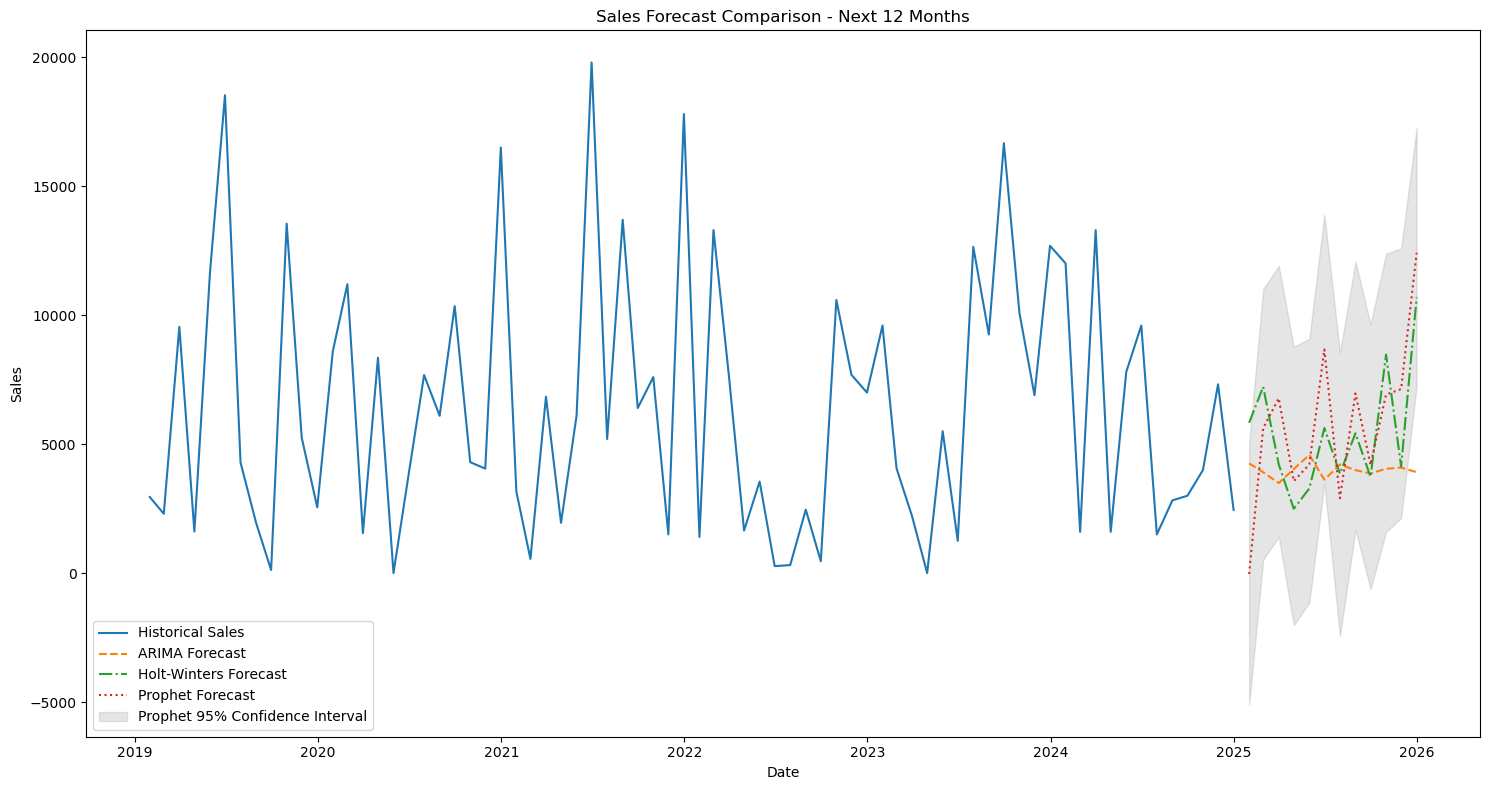

Sales forecasts saved to 'sales_forecasts.csv'


In [12]:
# Time series analysis for sales forecasting
# Load the original data to keep date information intact
df = pd.read_csv('/Users/arjavkasliwal/Downloads/balanced_supply_chain_data.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Create time series data by grouping by date
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.set_index('Order Date')
daily_sales = daily_sales.sort_index()

# Resample to different time frequencies
daily_sales_ts = daily_sales.resample('D').sum()
weekly_sales_ts = daily_sales.resample('W').sum()
monthly_sales_ts = daily_sales.resample('M').sum()

# Fill missing values (days with no sales)
daily_sales_ts = daily_sales_ts.fillna(0)

# Plot the time series
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(daily_sales_ts)
plt.title('Daily Sales')
plt.subplot(3, 1, 2)
plt.plot(weekly_sales_ts)
plt.title('Weekly Sales')
plt.subplot(3, 1, 3)
plt.plot(monthly_sales_ts)
plt.title('Monthly Sales')
plt.tight_layout()
plt.show()

# Decompose the time series to understand trends and seasonality
# Use monthly data for clearer patterns
decomposition = seasonal_decompose(monthly_sales_ts, model='additive', period=12)
fig = decomposition.plot()
plt.figure(figsize=(16, 10))
fig.set_size_inches(15, 10)
plt.tight_layout()
plt.show()

# 1. ARIMA Model for sales forecasting
# Fit ARIMA model
arima_model = ARIMA(monthly_sales_ts, order=(5,1,0))
arima_result = arima_model.fit()

# Generate ARIMA forecast
forecast_steps = 12  # Define the number of future periods to forecast
arima_forecast = arima_result.forecast(steps=forecast_steps)

# 2. Prophet Model for sales forecasting
# Prepare data for Prophet
prophet_data = pd.DataFrame({
    'ds': monthly_sales_ts.index,
    'y': monthly_sales_ts.values.flatten()
})

# Add holiday data if available
if 'Holiday_Flag' in df.columns:
    # Extract dates marked as holidays
    holidays = df[df['Holiday_Flag'] == 1]['Order Date'].dt.date.unique()
    holiday_df = pd.DataFrame({
        'holiday': 'holiday',
        'ds': pd.to_datetime(holidays)
    })
    
    # Initialize Prophet with holidays
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=holiday_df)
else:
    # Initialize Prophet without holidays
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add additional regressors if relevant
if 'Advertising_Spend' in df.columns:
    # Aggregate advertising spend by month
    monthly_ads = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Advertising_Spend'].mean().reset_index()
    monthly_ads.columns = ['ds', 'ads_spend']
    
    # Merge with prophet data
    prophet_data = prophet_data.merge(monthly_ads, on='ds', how='left')
    
    # Fill missing values
    prophet_data['ads_spend'] = prophet_data['ads_spend'].fillna(prophet_data['ads_spend'].mean())
    
    # Add regressor
    prophet_model.add_regressor('ads_spend')

# Fit Prophet model
prophet_model.fit(prophet_data)

# Create future dataframe for prediction
future = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M')

# Add regressor values to future dataframe if needed
if 'ads_spend' in prophet_data.columns:
    # Use the average ad spend for future predictions
    future['ads_spend'] = prophet_data['ads_spend'].mean()

# Generate forecast
prophet_forecast = prophet_model.predict(future)

# Plot Prophet forecast
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Sales Forecast - Next 12 Months')
plt.tight_layout()
plt.show()

# Plot Prophet components (trend, yearly seasonality, etc.)
fig = prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.show()

# 3. Holt-Winters Exponential Smoothing
# This works well for data with trend and seasonality
hw_model = ExponentialSmoothing(
    monthly_sales_ts,
    seasonal_periods=12,  # 12 months for yearly seasonality
    trend='add',
    seasonal='add'
)
hw_result = hw_model.fit()

# Generate forecast
hw_forecast = hw_result.forecast(forecast_steps)

# Compare all forecasting methods
plt.figure(figsize=(15, 8))
plt.plot(monthly_sales_ts.index, monthly_sales_ts, label='Historical Sales')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', linestyle='-.')
plt.plot(prophet_forecast['ds'][-forecast_steps:], prophet_forecast['yhat'][-forecast_steps:], label='Prophet Forecast', linestyle=':')
plt.fill_between(
    prophet_forecast['ds'][-forecast_steps:],
    prophet_forecast['yhat_lower'][-forecast_steps:],
    prophet_forecast['yhat_upper'][-forecast_steps:],
    color='gray', alpha=0.2, label='Prophet 95% Confidence Interval'
)
plt.title('Sales Forecast Comparison - Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Create a dataframe with all forecasts
forecast_dates = pd.date_range(start=monthly_sales_ts.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

forecasts_df = pd.DataFrame({
    'Date': forecast_dates,
    'ARIMA_Forecast': arima_forecast.values,
    'HoltWinters_Forecast': hw_forecast.values,
    'Prophet_Forecast': prophet_forecast['yhat'][-forecast_steps:].values,
    'Prophet_Lower_Bound': prophet_forecast['yhat_lower'][-forecast_steps:].values,
    'Prophet_Upper_Bound': prophet_forecast['yhat_upper'][-forecast_steps:].values
})

# Save the forecasts to CSV
forecasts_df.to_csv('sales_forecasts.csv', index=False)
print("Sales forecasts saved to 'sales_forecasts.csv'")

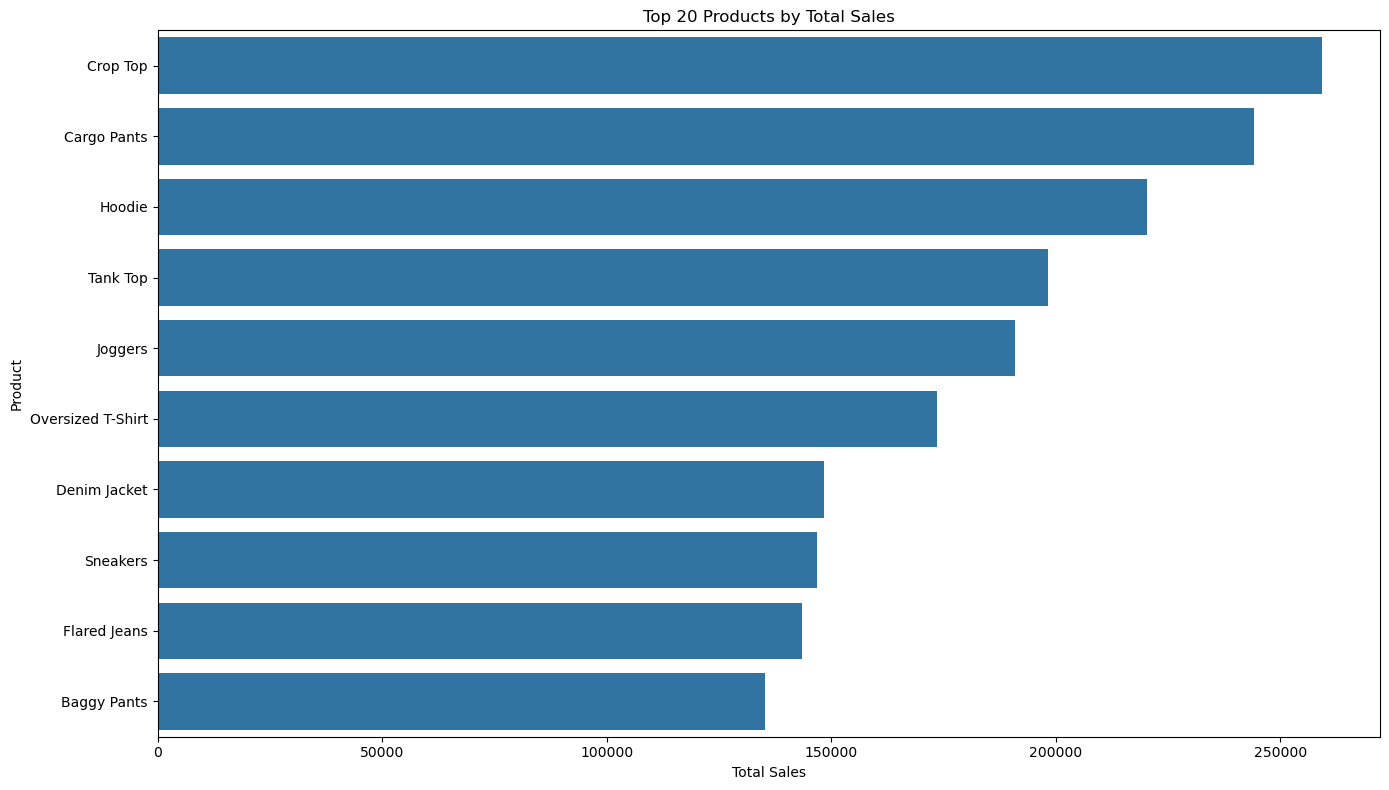

<Figure size 1500x800 with 0 Axes>

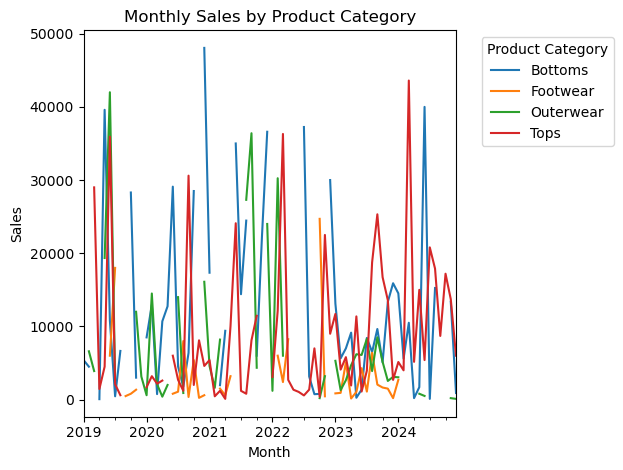

<Figure size 1500x800 with 0 Axes>

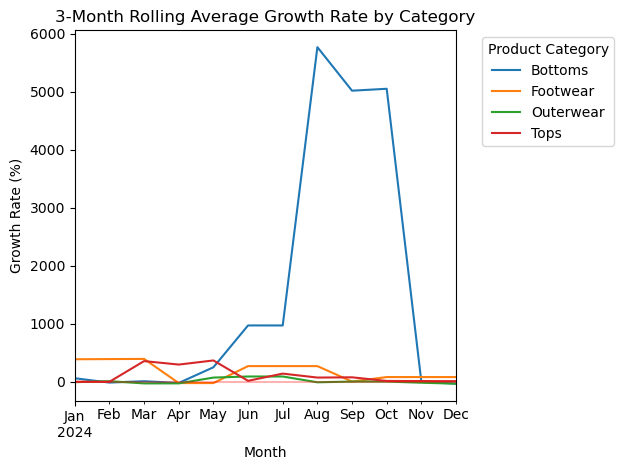

Fastest Growing Product Categories (Last 3 Months):
Footwear     77.777778
Tops          7.066790
Bottoms     -35.218972
Outerwear   -36.666667
dtype: float64

Declining Product Categories (Last 3 Months):
Bottoms     -35.218972
Outerwear   -36.666667
dtype: float64


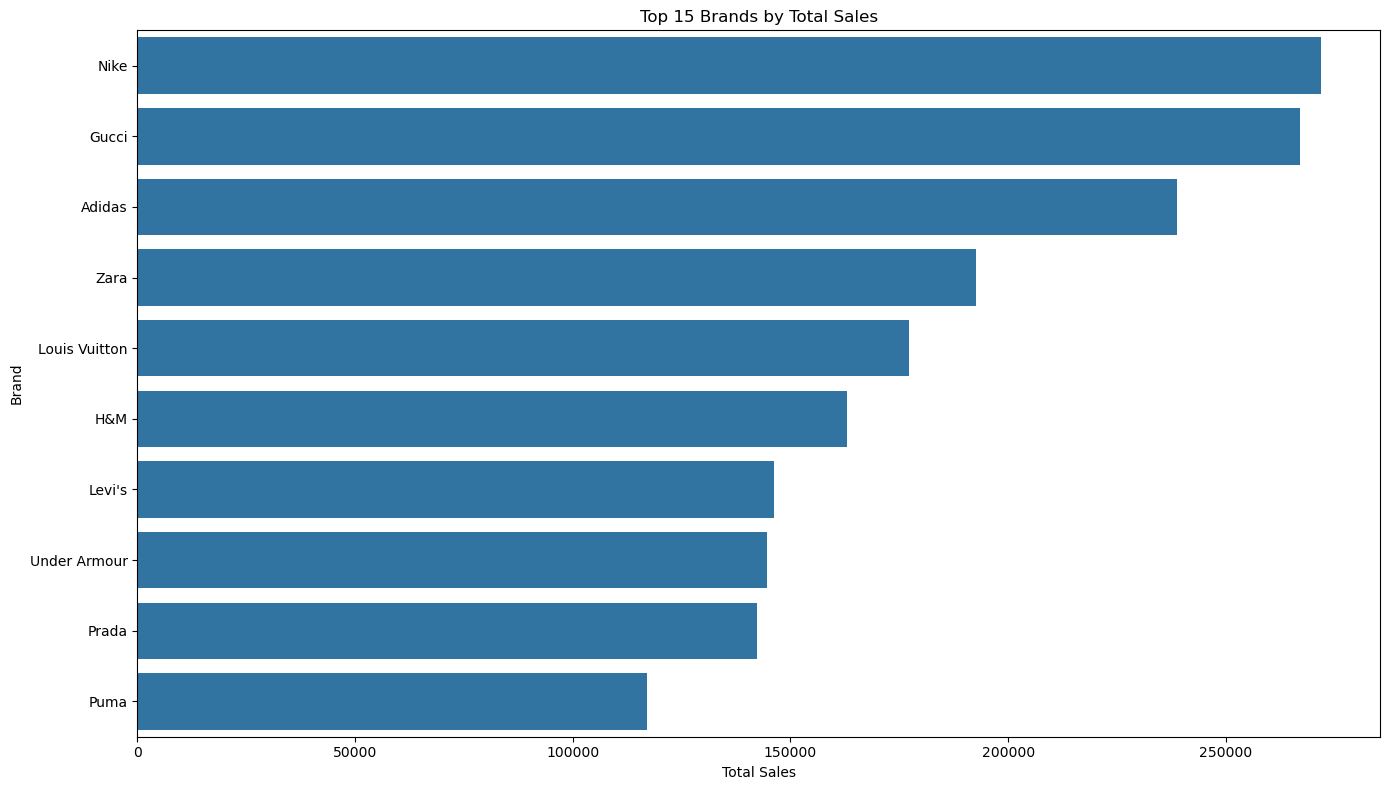

<Figure size 1500x800 with 0 Axes>

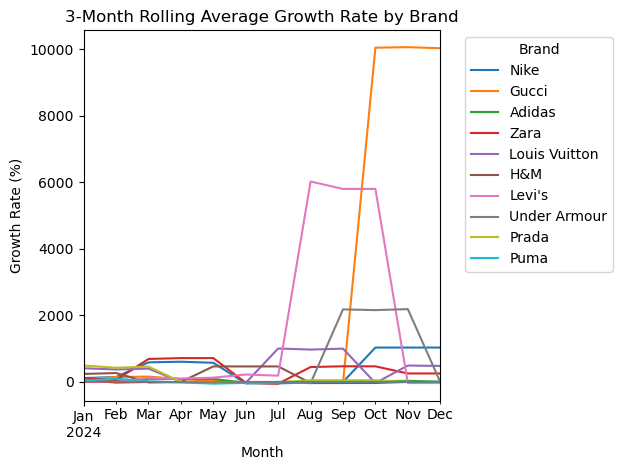

Fastest Growing Brands (Last 3 Months):
Gucci            10027.607115
Nike              1033.333333
Louis Vuitton      480.563769
Zara               254.861111
Adidas               6.913580
dtype: float64


13:12:17 - cmdstanpy - INFO - Chain [1] start processing
13:12:17 - cmdstanpy - INFO - Chain [1] done processing


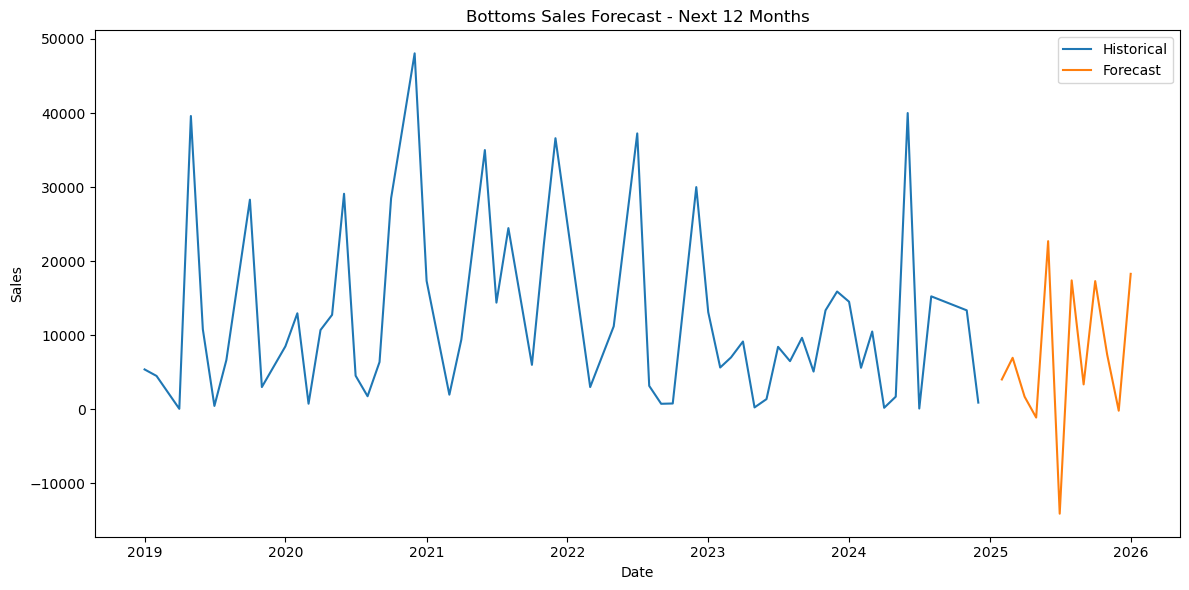

13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] done processing


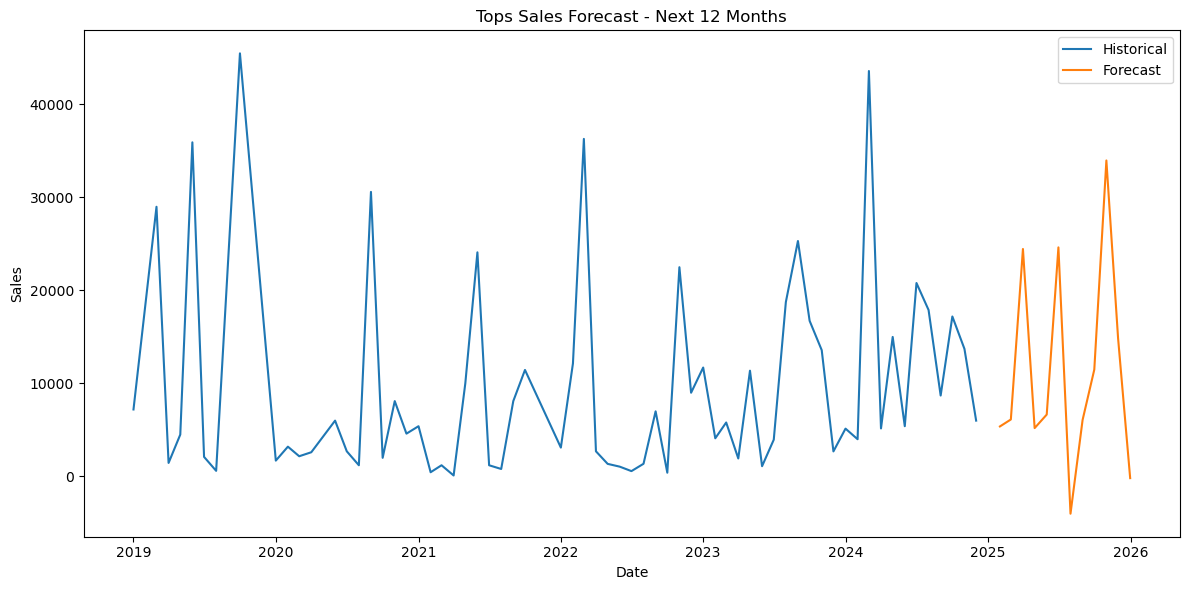

13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] done processing


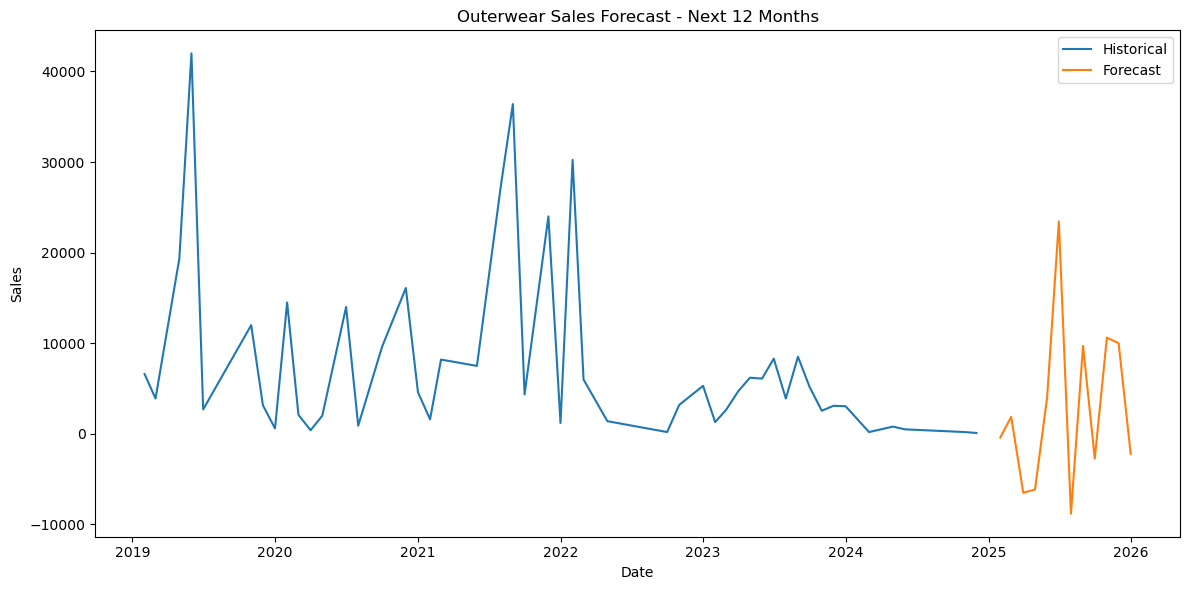

13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] done processing


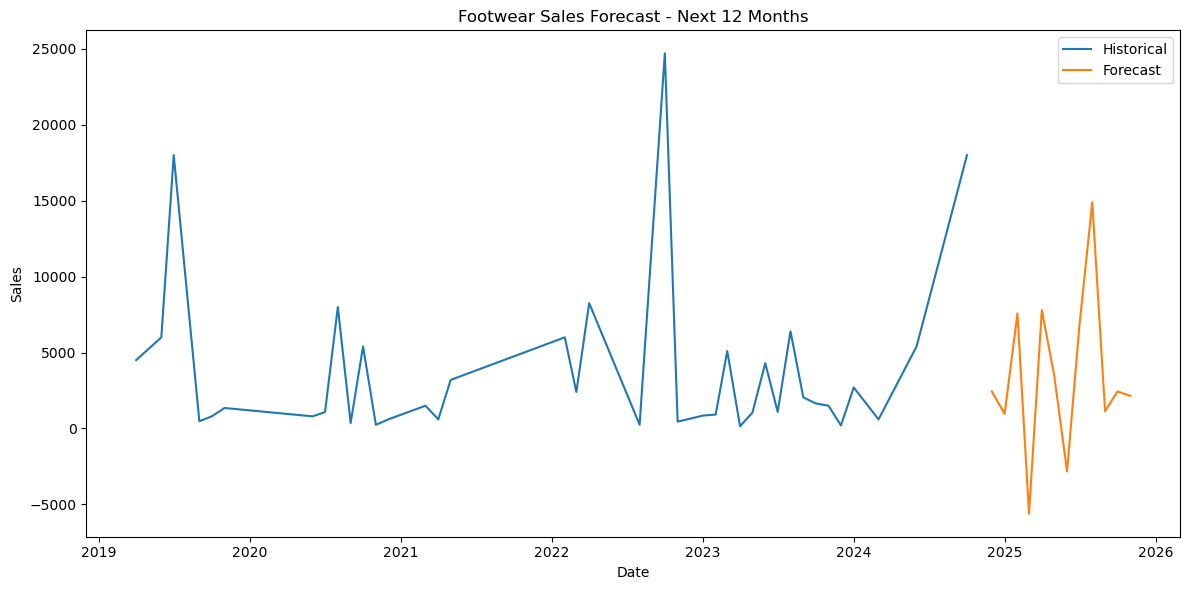

Category forecasts saved to 'category_forecasts.csv'


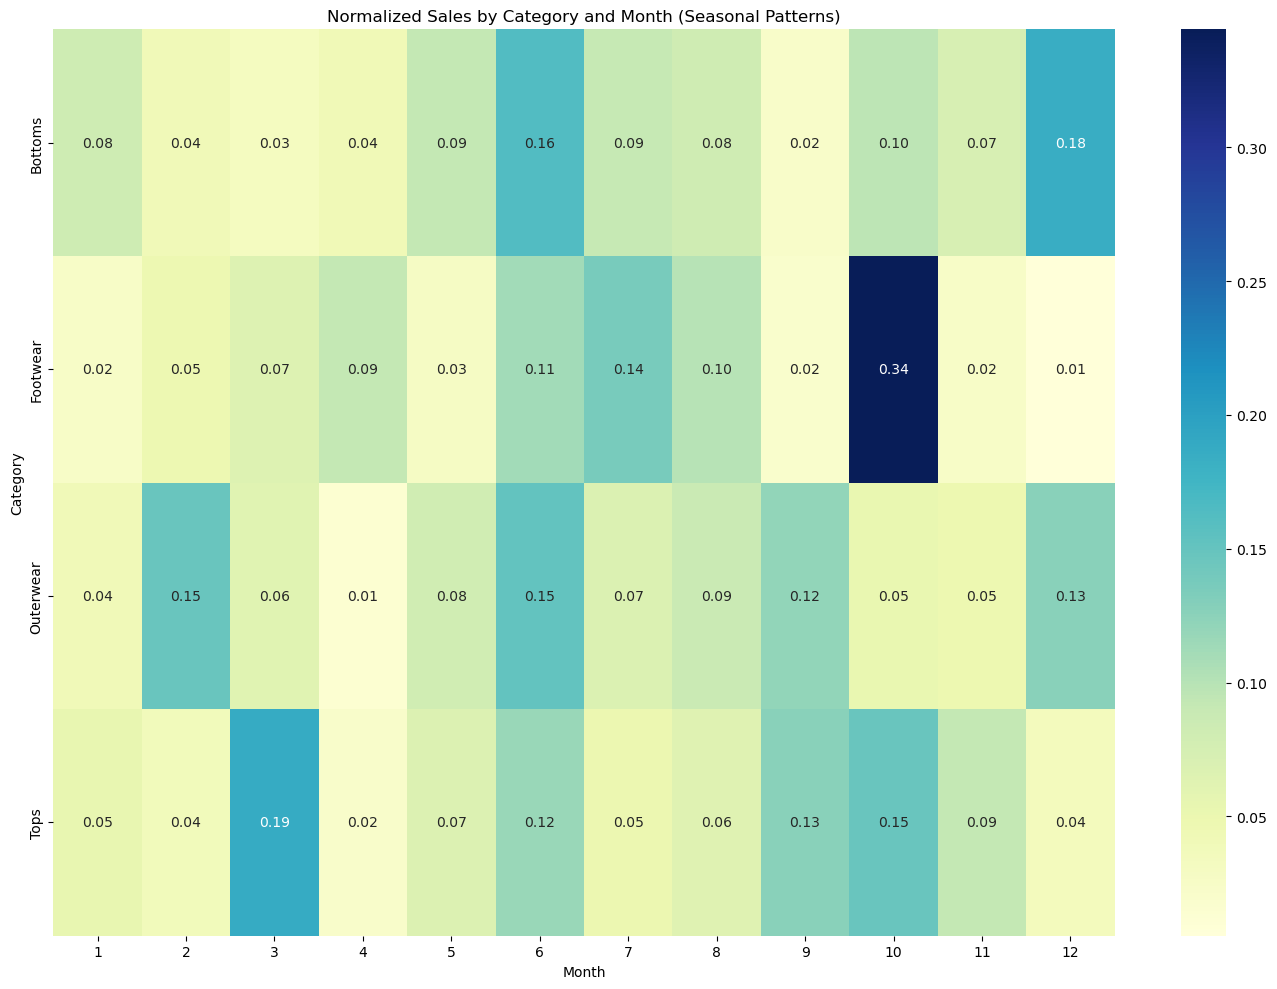

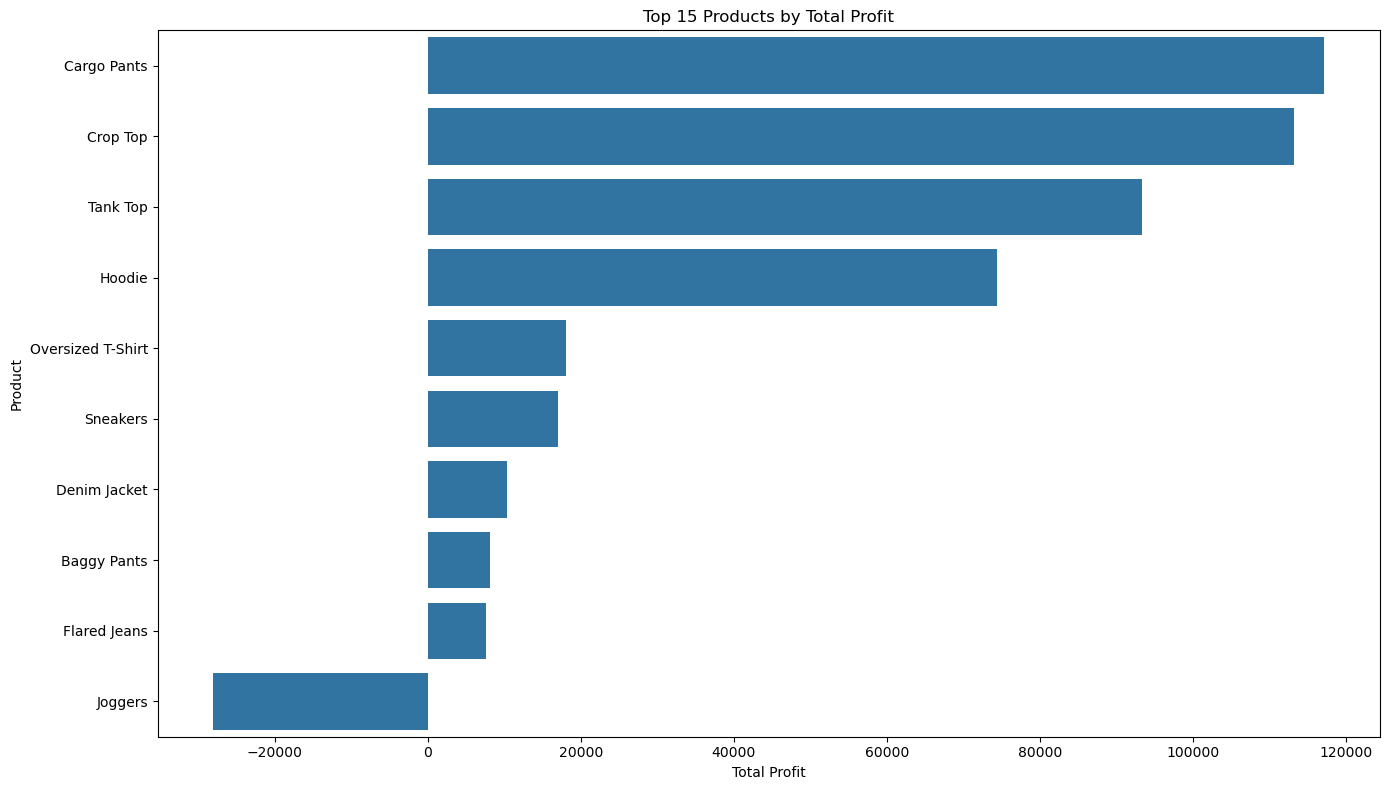


Top Product Associations:
             Product1           Product2  Count
11           Crop Top           Crop Top    423
8            Sneakers           Sneakers    343
0             Joggers            Joggers    284
7            Tank Top           Tank Top    273
36        Cargo Pants        Cargo Pants    209
37       Denim Jacket       Denim Jacket    202
35  Oversized T-Shirt  Oversized T-Shirt    195
3        Flared Jeans       Flared Jeans    184
15             Hoodie             Hoodie    177
1            Crop Top           Tank Top    172
42       Denim Jacket  Oversized T-Shirt    161
50            Joggers  Oversized T-Shirt    160
23        Baggy Pants        Baggy Pants    160
4        Flared Jeans           Sneakers    152
54           Crop Top  Oversized T-Shirt    132


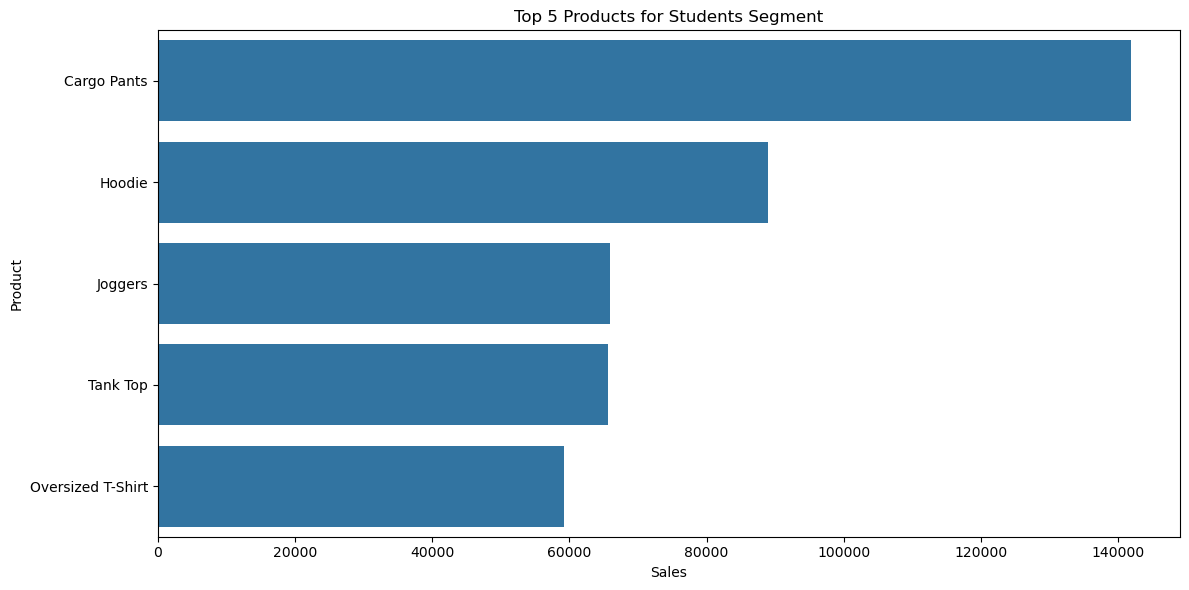

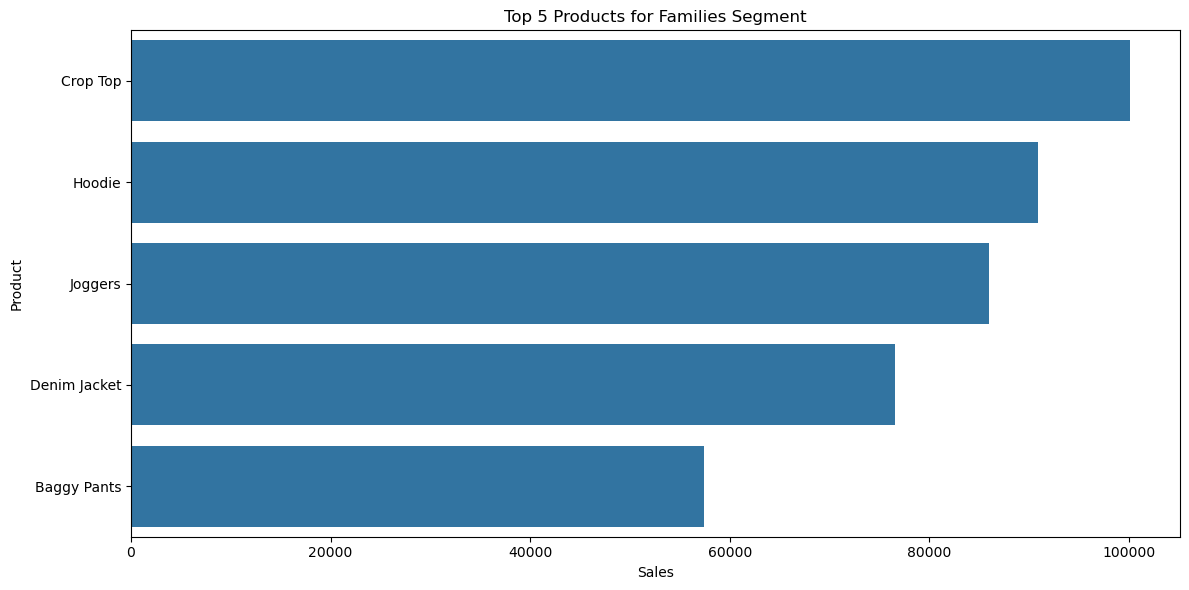

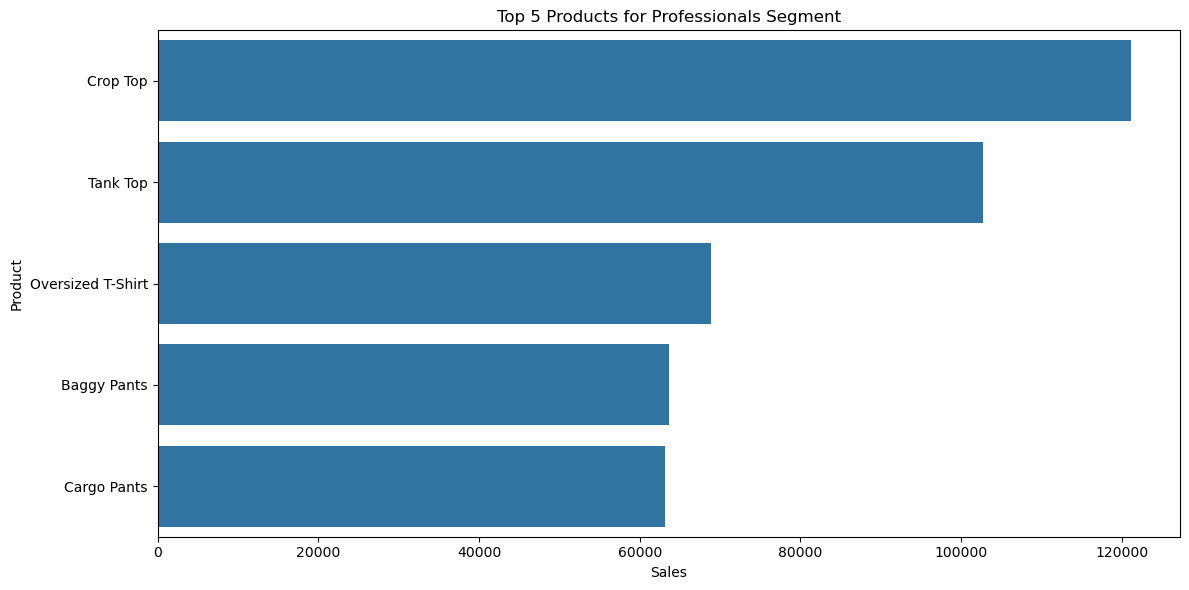


Products Needing Restocking (Less than 14 days until reorder point):
             Product  Current_Stock_Level  Reorder_Level  Days_Until_Reorder
3       Denim Jacket                   58             39            0.046716
7  Oversized T-Shirt                   68             39            0.061012
2           Crop Top                  142             32            0.154864
5             Hoodie                  161             18            0.236959
9           Tank Top                  164             14            0.276027
8           Sneakers                  174              9            0.409917
1        Cargo Pants                  475             14            0.689102
6            Joggers                  488             45            0.846393
0        Baggy Pants                  347             28            0.860887
4       Flared Jeans                  438              6            1.099198


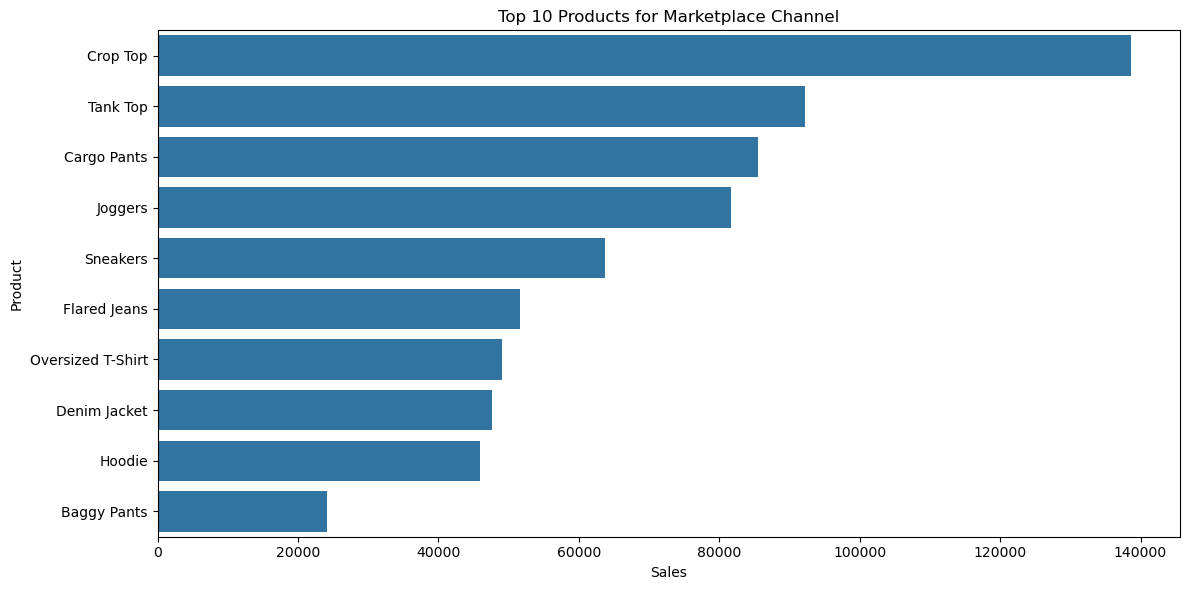

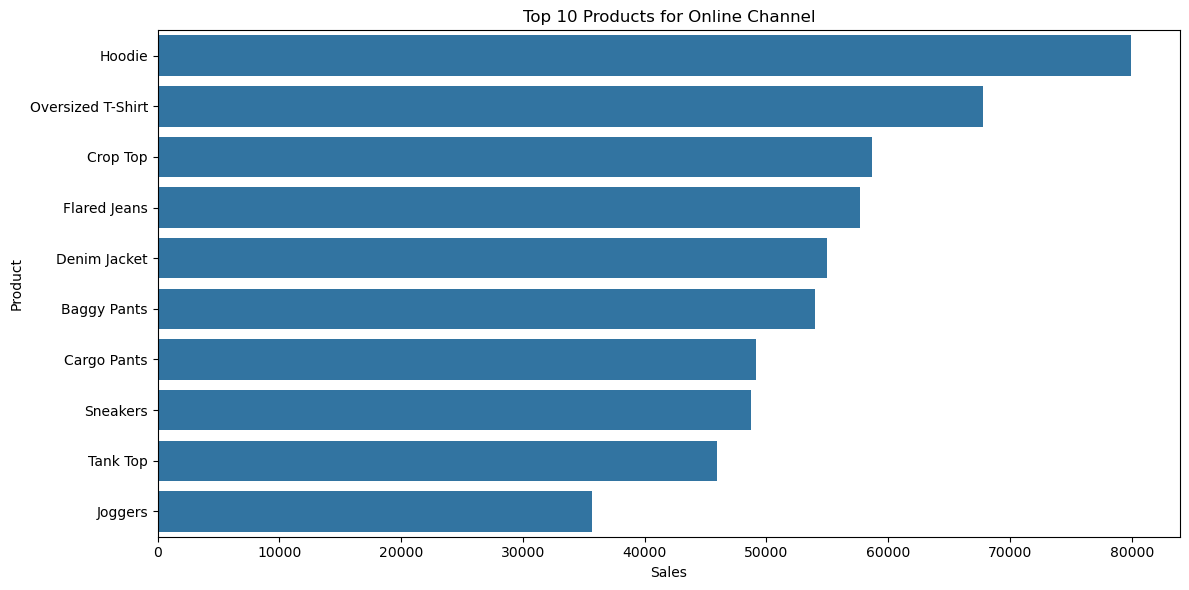

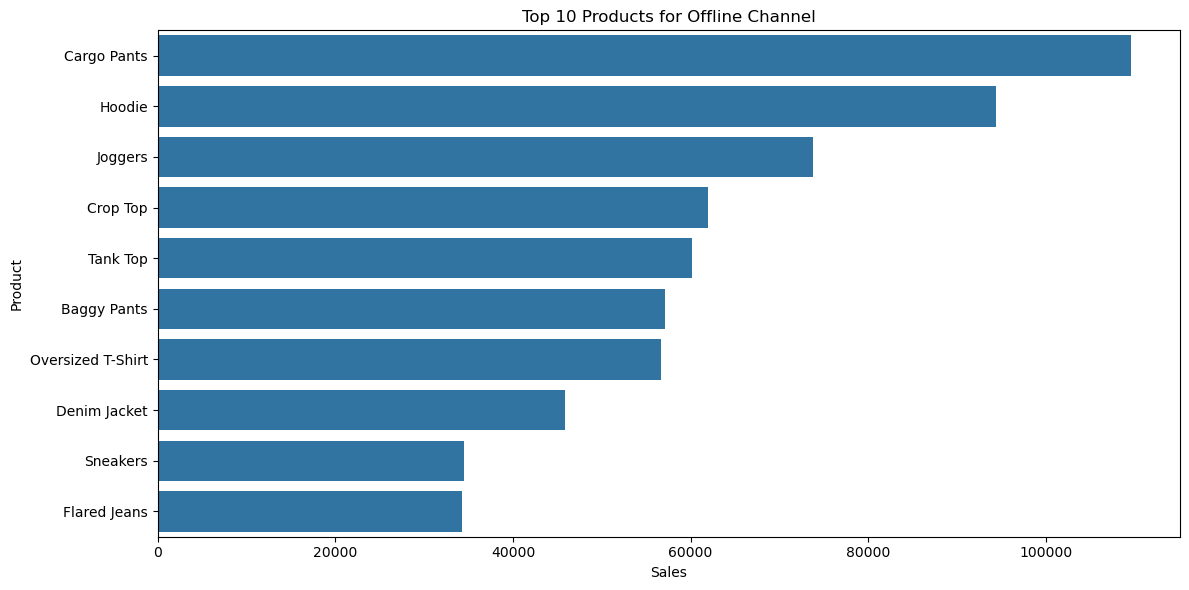

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Product trend analysis
df = pd.read_csv('/Users/arjavkasliwal/Downloads/finaldatasetecom.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'])

# 1. Identify top selling products
product_sales = df.groupby('Product')['Sales'].sum().sort_values(ascending=False)
top_products = product_sales.head(20)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 20 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# 2. Product category trends over time
# Monthly sales by category
df['YearMonth'] = df['Order Date'].dt.to_period('M')
category_monthly = df.groupby(['YearMonth', 'Category'])['Sales'].sum().unstack()

plt.figure(figsize=(15, 8))
category_monthly.plot()
plt.title('Monthly Sales by Product Category')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate growth rate for each category
category_growth = pd.DataFrame()
for category in category_monthly.columns:
    # Calculate month-over-month growth
    category_growth[category] = category_monthly[category].pct_change() * 100

# Calculate 3-month average growth rate
category_growth_3m = category_growth.rolling(3).mean()

# Plot category growth rates (3-month average)
plt.figure(figsize=(15, 8))
category_growth_3m.iloc[-12:].plot()  # Last 12 months
plt.title('3-Month Rolling Average Growth Rate by Category')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Identify trending (fastest growing) categories
recent_growth = category_growth.iloc[-3:].mean().sort_values(ascending=False)
print("Fastest Growing Product Categories (Last 3 Months):")
print(recent_growth.head(5))

print("\nDeclining Product Categories (Last 3 Months):")
print(recent_growth[recent_growth < 0].head(5))

# 3. Brand performance analysis
brand_sales = df.groupby('Brand')['Sales'].sum().sort_values(ascending=False)
top_brands = brand_sales.head(15)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title('Top 15 Brands by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

# Brand growth trends
brand_monthly = df.groupby(['YearMonth', 'Brand'])['Sales'].sum().unstack()
brand_growth = pd.DataFrame()

for brand in top_brands.index:
    if brand in brand_monthly.columns:
        # Calculate month-over-month growth
        brand_growth[brand] = brand_monthly[brand].pct_change() * 100

# Calculate 3-month average growth rate for top brands
brand_growth_3m = brand_growth.rolling(3).mean()

# Plot brand growth rates (3-month average)
plt.figure(figsize=(15, 8))
brand_growth_3m.iloc[-12:][brand_growth_3m.columns[:10]].plot()  # Last 12 months, top 10 brands
plt.title('3-Month Rolling Average Growth Rate by Brand')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Identify trending (fastest growing) brands
recent_brand_growth = brand_growth.iloc[-3:].mean().sort_values(ascending=False)
print("Fastest Growing Brands (Last 3 Months):")
print(recent_brand_growth.head(5))

# 4. Product forecast for top categories
top_categories = category_monthly.sum().sort_values(ascending=False).head(5).index
category_forecasts = pd.DataFrame()

for category in top_categories:
    # Extract category data
    category_data = category_monthly[category].dropna()
    
    # Convert period index to datetime
    category_data.index = category_data.index.to_timestamp()
    
    # Prepare data for Prophet
    prophet_data = pd.DataFrame({
        'ds': category_data.index,
        'y': category_data.values
    })
    
    # Fit Prophet model
    category_model = Prophet(yearly_seasonality=True)
    category_model.fit(prophet_data)
    
    # Create future dataframe for prediction
    future = category_model.make_future_dataframe(periods=12, freq='M')
    
    # Generate forecast
    category_forecast = category_model.predict(future)
    
    # Save forecast to dataframe
    category_forecasts[f'{category}_forecast'] = category_forecast['yhat'][-12:].values
    
    # Plot category forecast
    plt.figure(figsize=(12, 6))
    plt.plot(category_data.index, category_data.values, label='Historical')
    plt.plot(
        pd.date_range(start=category_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M'),
        category_forecast['yhat'][-12:].values,
        label='Forecast'
    )
    plt.title(f'{category} Sales Forecast - Next 12 Months')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Add dates to category forecasts
category_forecasts['Date'] = pd.date_range(
    start=category_monthly.index[-1].to_timestamp() + pd.DateOffset(months=1),
    periods=12,
    freq='M'
)

# Save category forecasts to CSV
category_forecasts.to_csv('category_forecasts.csv', index=False)
print("Category forecasts saved to 'category_forecasts.csv'")

# 5. Seasonal product analysis
# Create a pivot table of category sales by month of year
seasonal_categories = df.copy()
seasonal_categories['Month'] = seasonal_categories['Order Date'].dt.month
category_by_month = seasonal_categories.groupby(['Category', 'Month'])['Sales'].sum().unstack()

# Normalize to show seasonal patterns
normalized_category = category_by_month.div(category_by_month.sum(axis=1), axis=0)

# Plot heatmap of seasonal category trends
plt.figure(figsize=(14, 10))
sns.heatmap(normalized_category, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Normalized Sales by Category and Month (Seasonal Patterns)')
plt.xlabel('Month')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# 6. Product profitability analysis
# Calculate profit for each transaction
df['Profit'] = df['Sales'] - (df['Cost_Price'] * df['Quantity'])
product_profit = df.groupby('Product')[['Sales', 'Profit']].sum()
product_profit['Profit_Margin'] = (product_profit['Profit'] / product_profit['Sales'] * 100).round(2)
product_profit = product_profit.sort_values('Profit', ascending=False)

# Plot top profitable products
plt.figure(figsize=(14, 8))
sns.barplot(x=product_profit['Profit'].head(15).values, y=product_profit.head(15).index)
plt.title('Top 15 Products by Total Profit')
plt.xlabel('Total Profit')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# 7. Cross-category analysis (product associations)
# Simple analysis of products frequently bought together
product_pairs = pd.DataFrame(columns=['Product1', 'Product2', 'Count'])

# Group by order to find products bought together
order_products = df.groupby('Customer ID')['Product'].apply(list).reset_index()

# Count product co-occurrences (simplified approach)
product_associations = {}
for products in order_products['Product']:
    for i, p1 in enumerate(products):
        for p2 in products[i+1:]:
            # Sort product names to avoid duplicates
            key = tuple(sorted([p1, p2]))
            if key in product_associations:
                product_associations[key] += 1
            else:
                product_associations[key] = 1

# Convert to DataFrame for analysis
product_pairs_list = []
for (p1, p2), count in product_associations.items():
    if count > 2:  # Threshold for association
        product_pairs_list.append({'Product1': p1, 'Product2': p2, 'Count': count})

product_pairs = pd.DataFrame(product_pairs_list)
if not product_pairs.empty:
    product_pairs = product_pairs.sort_values('Count', ascending=False)
    
    # Display top product associations
    print("\nTop Product Associations:")
    print(product_pairs.head(15))

# 8. Customer segment analysis for products
segment_product_sales = df.groupby(['Customer_Segment', 'Product'])['Sales'].sum().reset_index()
pivot_segment_product = segment_product_sales.pivot_table(
    index='Product', 
    columns='Customer_Segment', 
    values='Sales',
    aggfunc='sum',
    fill_value=0
)

# Top products by customer segment
top_products_by_segment = {}
for segment in df['Customer_Segment'].unique():
    segment_data = segment_product_sales[segment_product_sales['Customer_Segment'] == segment]
    top_products_by_segment[segment] = segment_data.sort_values('Sales', ascending=False).head(5)

# Visualize top products for each segment
for segment, data in top_products_by_segment.items():
    plt.figure(figsize=(12, 6))
    sns.barplot(x=data['Sales'], y=data['Product'])
    plt.title(f'Top 5 Products for {segment} Segment')
    plt.xlabel('Sales')
    plt.ylabel('Product')
    plt.tight_layout()
    plt.show()

# 9. Stock and supply chain optimization
# Analyze stock levels vs. sales for top products
stock_analysis = df.groupby('Product')[['Sales', 'Current_Stock_Level', 'Reorder_Level']].agg({
    'Sales': 'sum',
    'Current_Stock_Level': 'first',  # Assuming current stock level is consistent for each product
    'Reorder_Level': 'first'
}).reset_index()

# Calculate days of supply 
# Assuming average daily sales
stock_analysis['Avg_Daily_Sales'] = stock_analysis['Sales'] / 365  # Simplistic approach
stock_analysis['Days_of_Supply'] = stock_analysis['Current_Stock_Level'] / stock_analysis['Avg_Daily_Sales']
stock_analysis['Days_Until_Reorder'] = (stock_analysis['Current_Stock_Level'] - stock_analysis['Reorder_Level']) / stock_analysis['Avg_Daily_Sales']

# Identify products needing restocking
products_to_restock = stock_analysis[stock_analysis['Days_Until_Reorder'] < 14].sort_values('Days_Until_Reorder')

print("\nProducts Needing Restocking (Less than 14 days until reorder point):")
if not products_to_restock.empty:
    print(products_to_restock[['Product', 'Current_Stock_Level', 'Reorder_Level', 'Days_Until_Reorder']])

# 10. Channel performance analysis by product
channel_product_sales = df.groupby(['Sales_Channel', 'Product'])['Sales'].sum().reset_index()
top_channel_products = channel_product_sales.sort_values('Sales', ascending=False).groupby('Sales_Channel').head(10)

# Plot top products by sales channel
for channel in df['Sales_Channel'].unique():
    channel_data = top_channel_products[top_channel_products['Sales_Channel'] == channel]
    if not channel_data.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(x=channel_data['Sales'], y=channel_data['Product'])
        plt.title(f'Top 10 Products for {channel} Channel')
        plt.xlabel('Sales')
        plt.ylabel('Product')
        plt.tight_layout()
        plt.show()

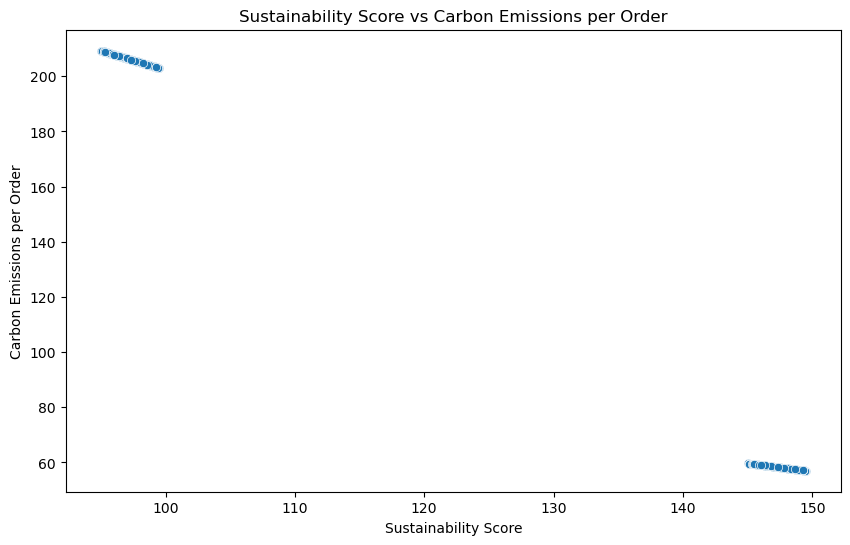

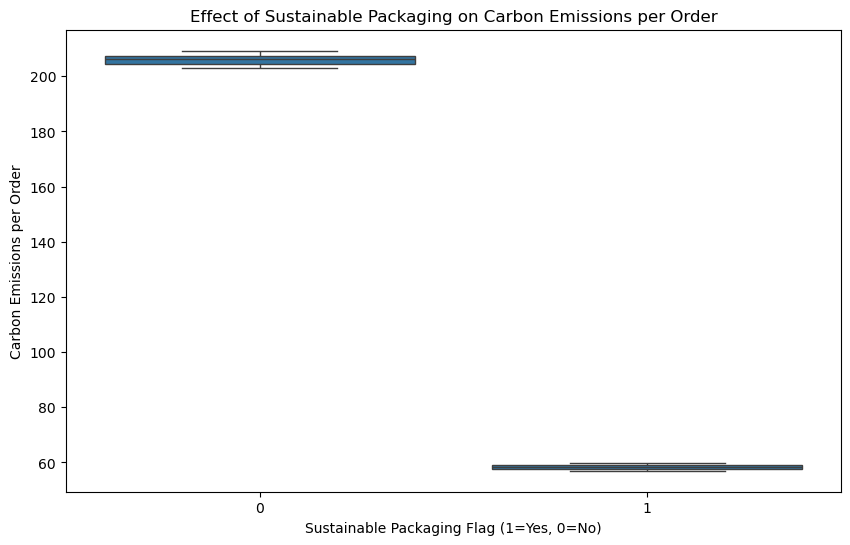

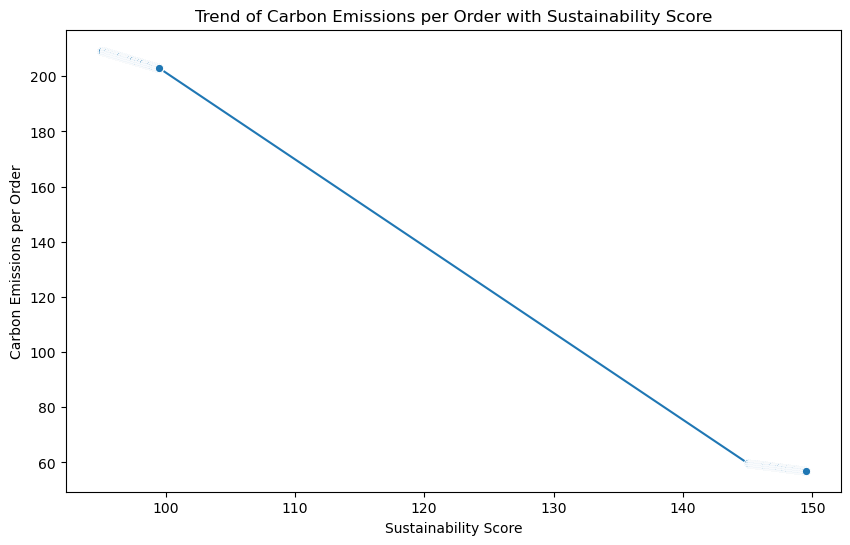

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/Users/arjavkasliwal/Downloads/finaldatasetecom.csv' 
df = pd.read_csv(file_path)

# Scatter plot to show the relationship between Sustainability_Score and Carbon_Emissions_Per_Order
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sustainability_Score', y='Carbon_Emissions_Per_Order', data=df)
plt.title('Sustainability Score vs Carbon Emissions per Order')
plt.xlabel('Sustainability Score')
plt.ylabel('Carbon Emissions per Order')
plt.show()

# Box plot to show the effect of Sustainable_Packaging_Flag on Carbon_Emissions_Per_Order
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sustainable_Packaging_Flag', y='Carbon_Emissions_Per_Order', data=df)
plt.title('Effect of Sustainable Packaging on Carbon Emissions per Order')
plt.xlabel('Sustainable Packaging Flag (1=Yes, 0=No)')
plt.ylabel('Carbon Emissions per Order')
plt.show()

# Line plot to show the trend of Carbon_Emissions_Per_Order with Sustainability_Score
plt.figure(figsize=(10, 6))
sns.lineplot(x='Sustainability_Score', y='Carbon_Emissions_Per_Order', data=df, marker='o')
plt.title('Trend of Carbon Emissions per Order with Sustainability Score')
plt.xlabel('Sustainability Score')
plt.ylabel('Carbon Emissions per Order')
plt.show()